In [1]:
# Comprobamos el environment
# ==============================================================================
import sys

print(sys.version)
print(sys.path)
print("---")
print(sys.executable)

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
['/opt/anaconda3/envs/practica1b/lib/python312.zip', '/opt/anaconda3/envs/practica1b/lib/python3.12', '/opt/anaconda3/envs/practica1b/lib/python3.12/lib-dynload', '', '/Users/oscar/.local/lib/python3.12/site-packages', '/opt/anaconda3/envs/practica1b/lib/python3.12/site-packages', '/opt/anaconda3/envs/practica1b/lib/python3.12/site-packages/setuptools/_vendor']
---
/opt/anaconda3/envs/practica1b/bin/python


<h1 style="font-size: 36px;"> Selección y evaluación del modelo final</h1>

El objetivo principal de este notebook es definir un modelo base, compararlo con otros modelos, seleccionar el más adecuado, optimizar sus hiperparámetros y, finalmente, evaluar el rendimiento del modelo seleccionado.

# Librerías:

Las librerías utilizadas en este notebook son:

In [25]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from collections import Counter

# Gráficos
# ==============================================================================
import seaborn as sns
from matplotlib import pyplot as plt
import scikitplot as skplt

# Manejo de módulos
# ==============================================================================
import sys
import importlib

# Procesamiento de datos
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Modelos de clasificación
# ==============================================================================
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
    ExtraTreesClassifier
)
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Validación y partición
# ==============================================================================
from sklearn.model_selection import (
    train_test_split, cross_validate, KFold
)

# Métricas de evaluación
# ==============================================================================
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, fbeta_score, f1_score, 
    precision_score, recall_score, confusion_matrix, roc_curve, auc, 
    roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay, 
    classification_report, make_scorer
)
from sklearn.model_selection import RandomizedSearchCV

# Técnicas de balanceo de datos
# ==============================================================================
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Guardado de modelos
# ==============================================================================
import pickle
from joblib import dump, load

In [3]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Configuración de la semilla 
# ==============================================================================
seed = 42

# Funciones:

Importamos las funciones necesarias para este notebook.

In [26]:
import sys
sys.path.append("../scr/")
import funciones 
sys.path.remove('../scr/')

In [27]:
# Recarga el módulo
# ==============================================================================
sys.path.append("../scr/")
importlib.reload(funciones)
sys.path.remove('../scr/')

# Datos: 

Importamos los datasets procesados en el notebook anterior, los cuales incluyen la selección de variables que discutimos previamente. Como hemos comprobado, la selección de variables realizada con la regularización de Ridge es efectiva y no afecta negativamente al rendimiento de los modelos.

In [5]:
# Datos de entrenamiento
# ==============================================================================
path_folder_train = "../data/interim/train_pd_data_preprocessing_features.csv"
pd_loan_train = pd.read_csv(path_folder_train)

# Datos de test
# ==============================================================================
path_folder_test = "../data/interim/test_pd_data_preprocessing_features.csv"
pd_loan_test = pd.read_csv(path_folder_test)

In [6]:
# Datos de entrenamiento
# ==============================================================================
X_train_scaled_t = pd_loan_train.drop('TARGET', axis=1)
y_train = pd_loan_train['TARGET']

# Datos de test
# ==============================================================================
X_test_scaled_t = pd_loan_test.drop('TARGET', axis=1)
y_test = pd_loan_test['TARGET']

# Modelado: 

El objetivo es encontrar el mejor modelo utilizando los datos disponibles. Para eso, lo primero es entender qué tipo de problema estamos resolviendo y qué modelos podrían funcionar mejor. Con esta información, vamos a probar distintos enfoques y comparar sus resultados para determinar cuál es el más efectivo.

Empezaremos con modelos simples y, poco a poco, probaremos otros más complejos. En cada etapa, analizaremos los resultados y evaluaremos si el tiempo y la complejidad adicionales valen la mejora en el rendimiento. Al principio, usaremos modelos con hiperparámetros por defecto, sin hacer ajustes, para ver qué desempeño básico ofrecen.

Como hemos mencionado, el objetivo de esta práctica es ayudar a un banco a tomar mejores decisiones al aprobar préstamos bancarios, analizando datos históricos de solicitudes. Buscamos desarrollar un modelo que pueda identificar a los clientes con y sin problemas financieros, prestando especial atención a aquellos clientes no solventes para minimizar el riesgo de pérdidas económicas.

Como se mencionó antes, el dataset presenta cierto desequilibrio, ya que la mayoría de los clientes no tienen problemas para pagar el préstamo. La clase minoritaria representa entre el 1% y el 20% del total, lo cual considero un desequilibrio moderado. Para abordar esto, he probado algunas técnicas de muestreo y ajuste y he comparado el rendimiento de los modelos en el dataset original con las variables seleccionadas y en el dataset ajustado para manejar el desequilibrio.

Por último, realizaré una búsqueda de hiperparámetros para optimizar el modelo en el mejor dataset, utilizando la técnica de validación cruzada.



## Modelo Dummy:

Antes de probar modelos más complejos, vamos a definir el modelo base, utilizando el modelo Dummy. Este es un modelo muy simple que siempre predice la clase más frecuente, sin analizar patrones en los datos. El objetivo del modelo base es darnos una referencia inicial para comparar y determinar si otros modelos más avanzados realmente aportan una mejora significativa en el rendimiento.

In [7]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_scaled_t, y_train)

y_pred_dummy = dummy.predict(X_test_scaled_t)


    Accuracy: 0.91927
    Balanced Accuracy: 0.50000
    F2 score: 0.00000
    F1 score: 0.00000
    Precision: 0.00000
    Recall: 0.00000
    


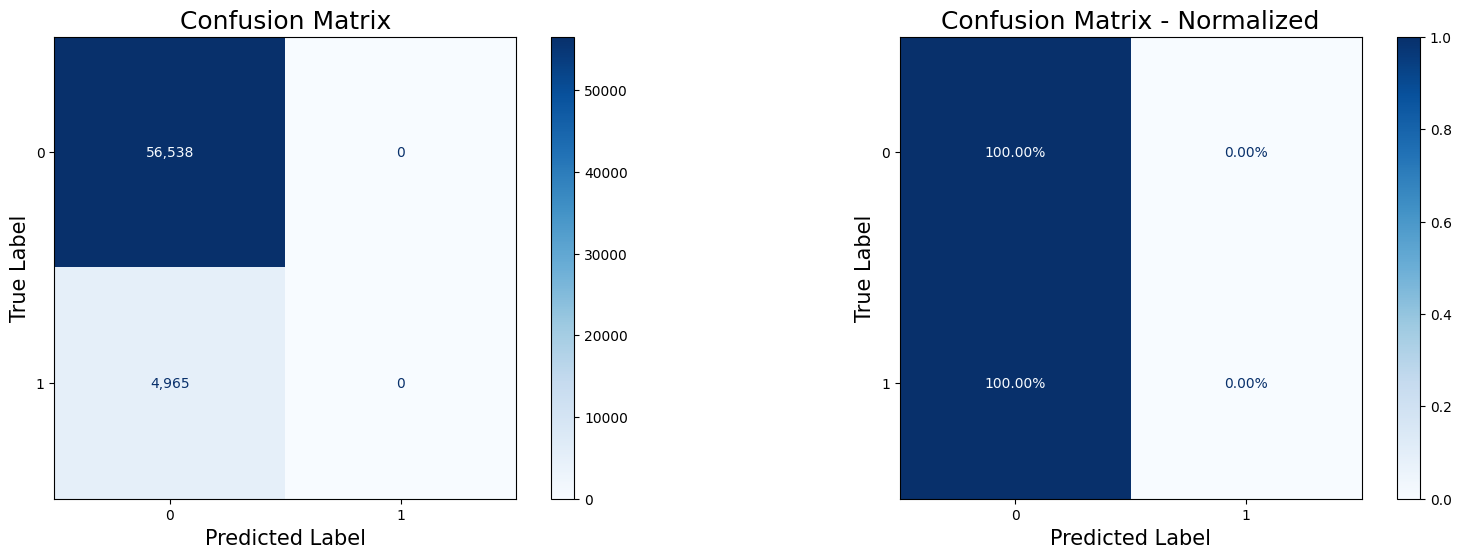

In [11]:
# Evaluamos el modelo que predice siempre la clase más frecuente
# ==============================================================================
funciones.evaluate_model(y_test, y_pred_dummy)

## Selección de modelos:

Voy a probar varios modelos para encontrar el que mejor se adapte a nuestros datos. La idea es comparar enfoques más clásicos con otros más sofisticados. Por ahora, planeo probar lo siguiente:

- RandomForestClassifier: Un modelo robusto basado en múltiples árboles de decisión.


- GradientBoostingClassifier: Otro enfoque basado en árboles, pero más enfocado en ajustar errores secuenciales.


- AdaBoostClassifier: Combina varios clasificadores débiles para formar uno fuerte.


- LogisticRegression: Un modelo simple pero a menudo muy efectivo para problemas de clasificación.


- GaussianNB: Naive Bayes, rápido y fácil de entender, ideal para probar resultados básicos.


- XGBClassifier: Un modelo basado en Gradient Boosting muy eficiente y popular.


- LGBMClassifier: Otro modelo basado en LightGBM, rápido y con buenos resultados en muchos casos.


- DecisionTreeClassifier: Un árbol de decisión básico, fácil de interpretar y rápido de entrenar.


- ExtraTreesClassifier: Similar al RandomForest, pero con más aleatorización.


He decidido incluir estos modelos adicionales porque, además de los clásicos recomendados por documentación (como RandomForest y XGBoost), quiero probar enfoques que puedan aportar un valor adicional. La idea es probar todos estos modelos, analizar su rendimiento y compararlos para determinar cuál ofrece la mejor combinación de eficiencia y precisión para este proyecto.

Para elegir el mejor modelo, necesitamos fijarnos en varias métricas. La accuracy nos dice cuántas predicciones se hicieron correctamente, mientras que la balanced accuracy ayuda a manejar desequilibrios entre clases. El F1 Score combina precisión y recall, y el F2 Score le da más peso al recall. La precision muestra qué tan bien el modelo evita falsos positivos, y el recall indica cuántos positivos reales se detectaron. Por último, la matriz de confusión nos da una visión clara de todos los aciertos y errores.

In [12]:
# Lista de clasificadores
# ==============================================================================
classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    LogisticRegression(),
    GaussianNB(),
    XGBClassifier(),
    LGBMClassifier(),
    DecisionTreeClassifier(),
    ExtraTreesClassifier(),
]


Classifier: RandomForestClassifier()
Model Score: 0.919

    Accuracy: 0.91930
    Balanced Accuracy: 0.50525
    F2 score: 0.01427
    F1 score: 0.02245
    Precision: 0.50893
    Recall: 0.01148
    


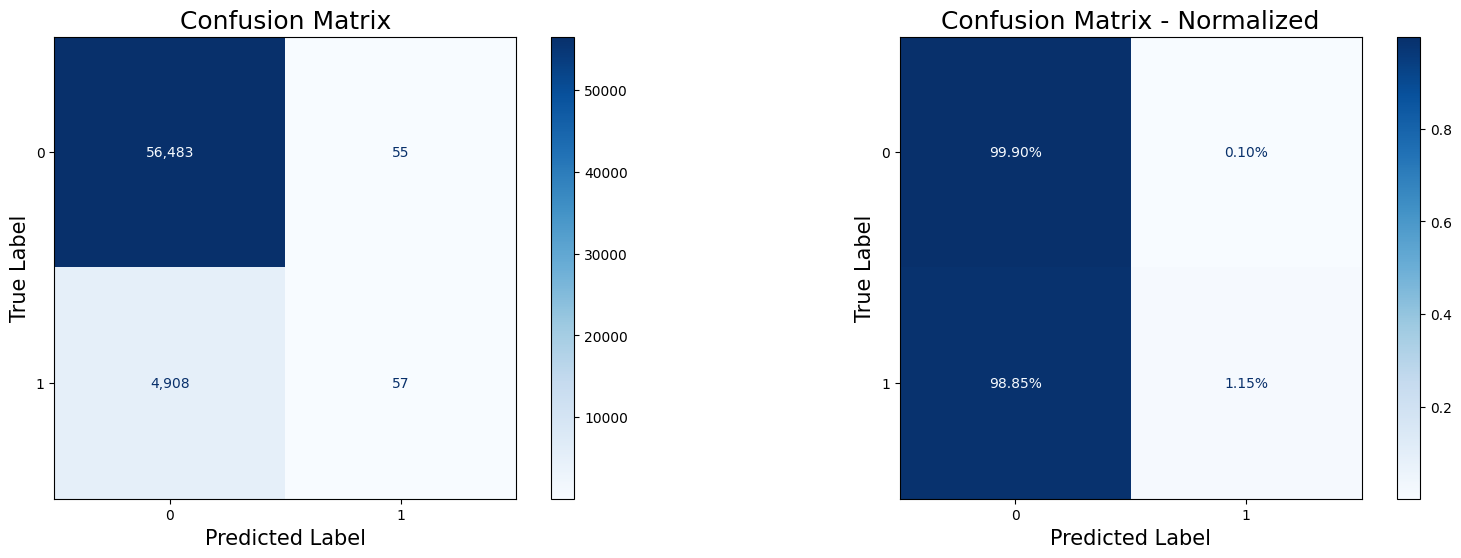


Classifier: GradientBoostingClassifier()
Model Score: 0.920

    Accuracy: 0.91966
    Balanced Accuracy: 0.50738
    F2 score: 0.01951
    F1 score: 0.03061
    Precision: 0.59091
    Recall: 0.01571
    


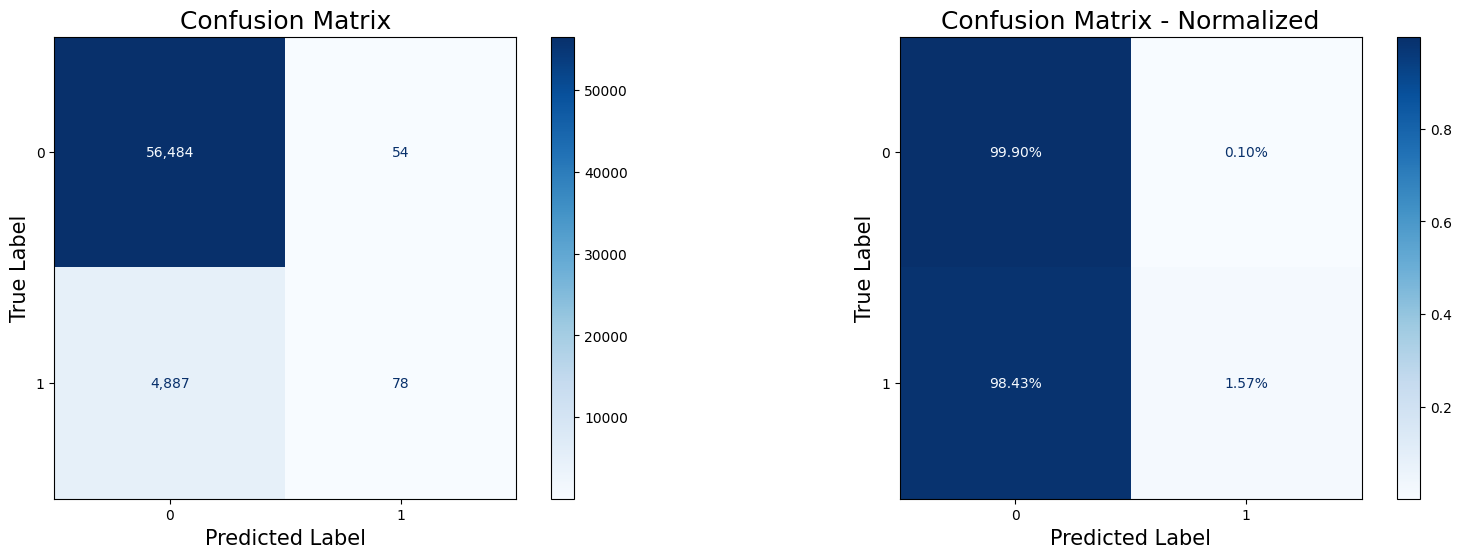


Classifier: AdaBoostClassifier()
Model Score: 0.919

    Accuracy: 0.91921
    Balanced Accuracy: 0.50851
    F2 score: 0.02319
    F1 score: 0.03608
    Precision: 0.48947
    Recall: 0.01873
    


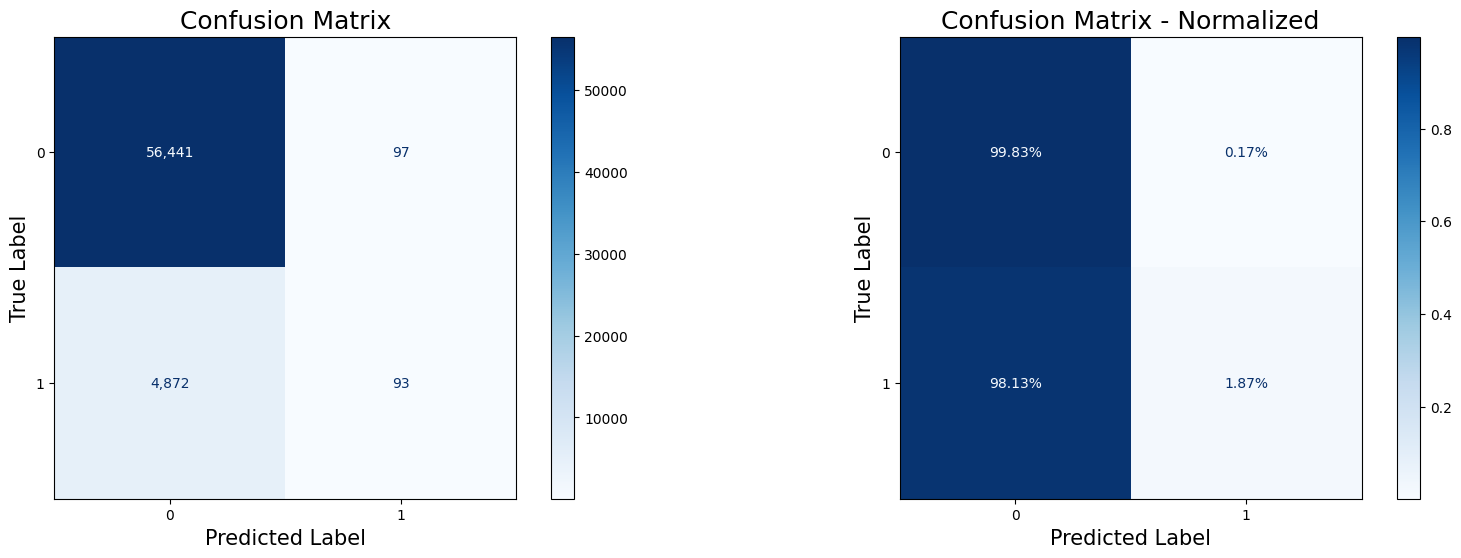


Classifier: LogisticRegression()
Model Score: 0.918

    Accuracy: 0.91822
    Balanced Accuracy: 0.50971
    F2 score: 0.02779
    F1 score: 0.04263
    Precision: 0.38754
    Recall: 0.02256
    


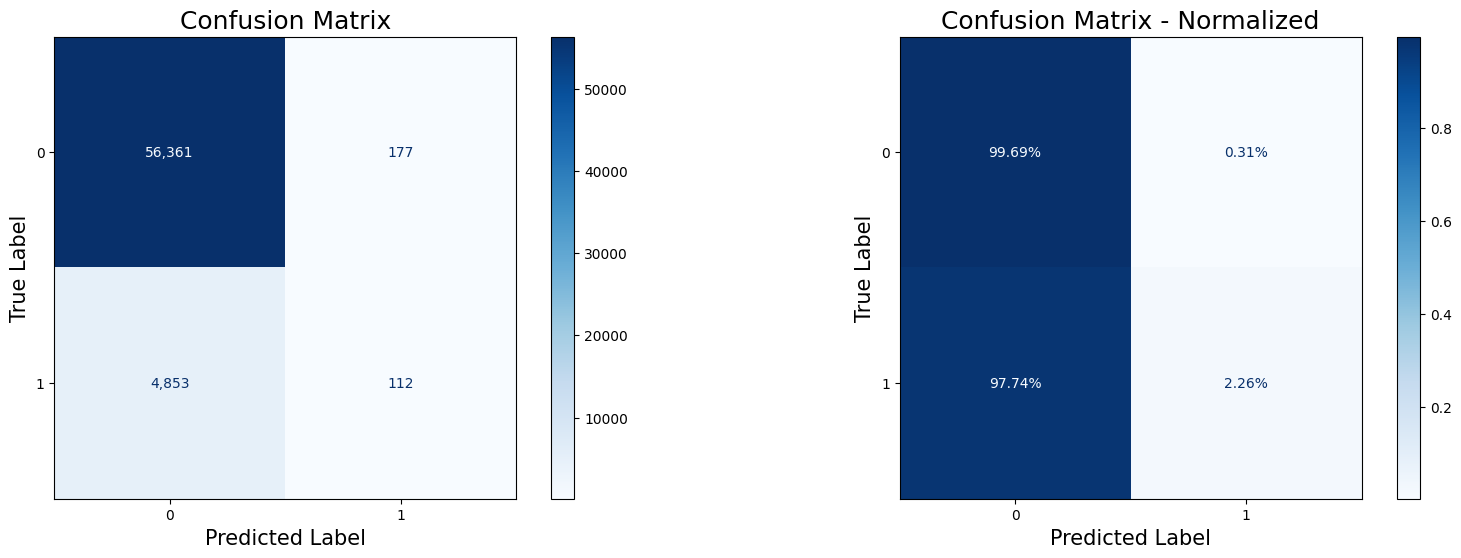


Classifier: GaussianNB()
Model Score: 0.919

    Accuracy: 0.91927
    Balanced Accuracy: 0.50000
    F2 score: 0.00000
    F1 score: 0.00000
    Precision: 0.00000
    Recall: 0.00000
    


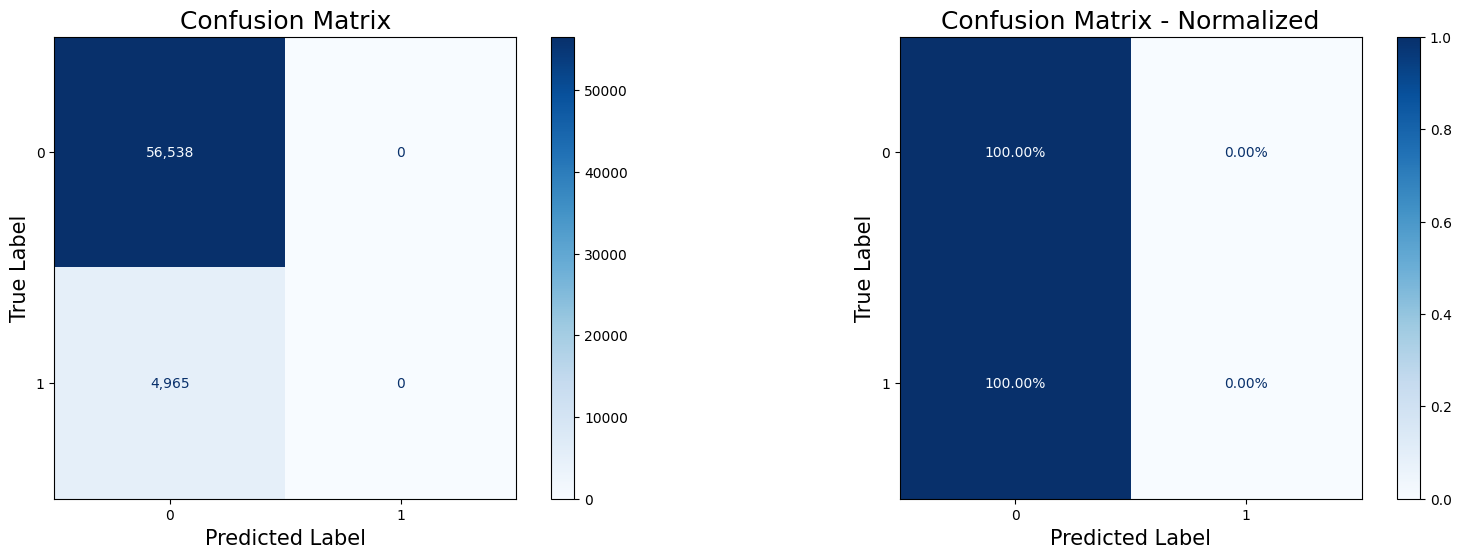


Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Model Score: 0.919

    Accuracy: 0.91900
    Balanced Accuracy: 0.50747
    F2 score: 0.02071
    F1 score: 0.03225
    Precision: 0.45355
    Recall: 0.01672
    


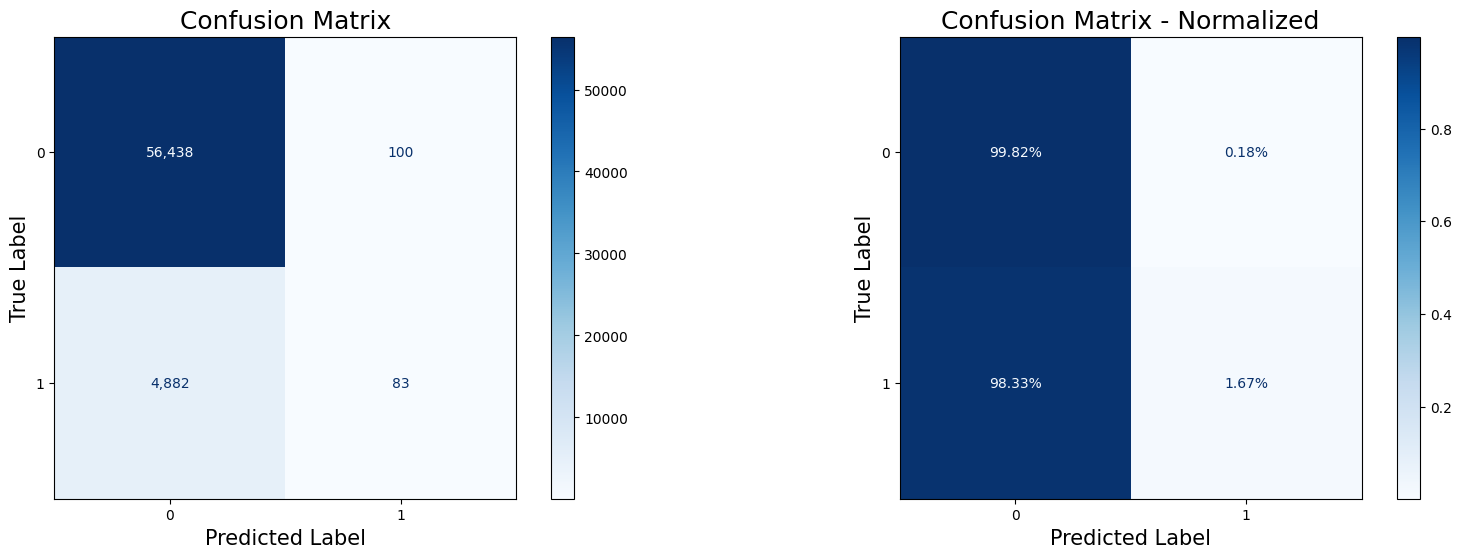

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2510
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482

Classifier: LGBMClassifier()
Model Score: 0.920

    Accuracy: 0.91960
    Balanced Accuracy: 0.50606
    F2 score: 0.01603
    F1 score: 0.02523
    Precision: 0.59259
    Recall: 0.01289
    


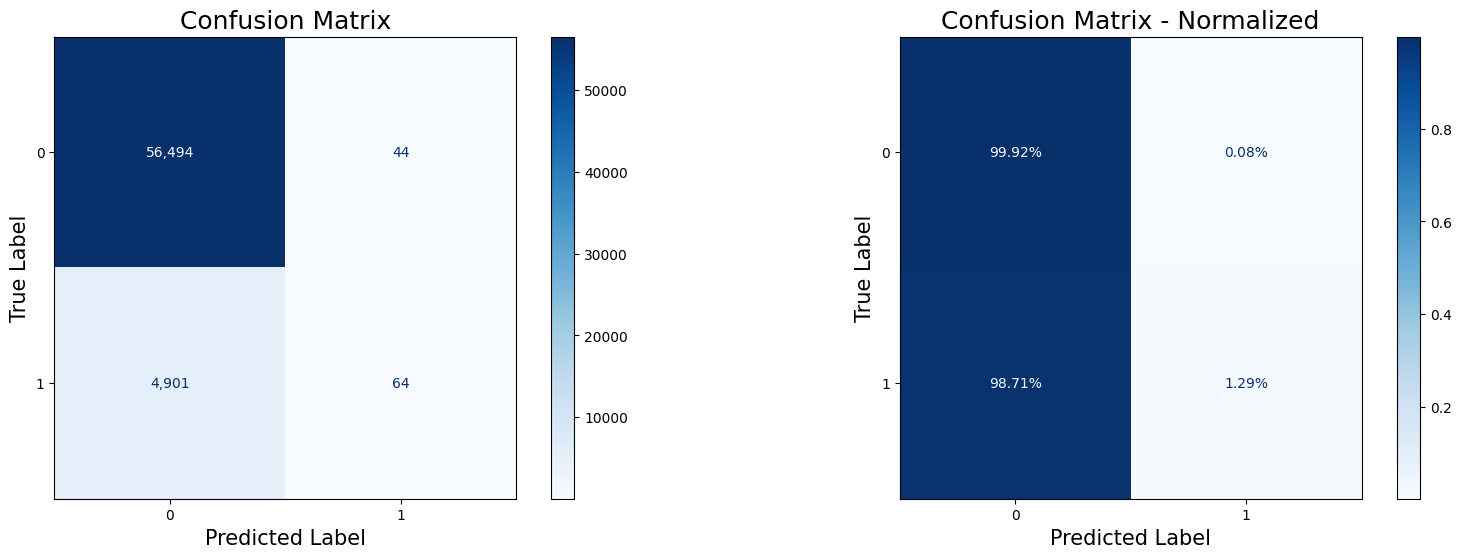


Classifier: DecisionTreeClassifier()
Model Score: 0.852

    Accuracy: 0.85227
    Balanced Accuracy: 0.54145
    F2 score: 0.16513
    F1 score: 0.15730
    Precision: 0.14578
    Recall: 0.17080
    


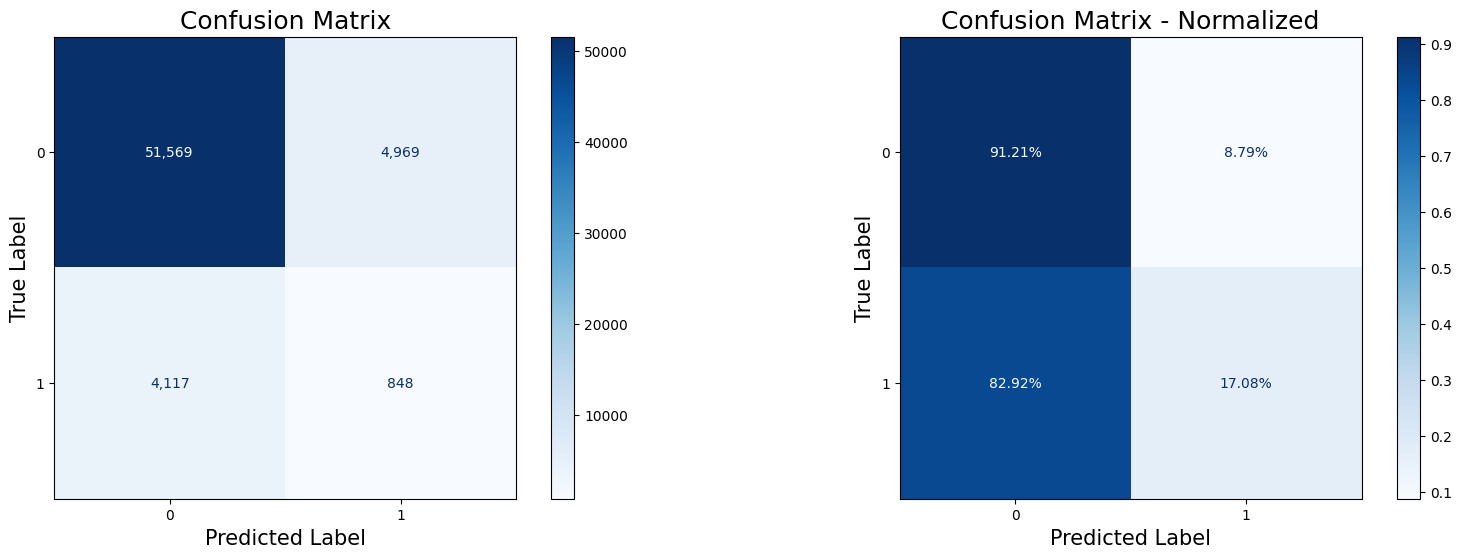


Classifier: ExtraTreesClassifier()
Model Score: 0.919

    Accuracy: 0.91942
    Balanced Accuracy: 0.50642
    F2 score: 0.01726
    F1 score: 0.02709
    Precision: 0.53488
    Recall: 0.01390
    


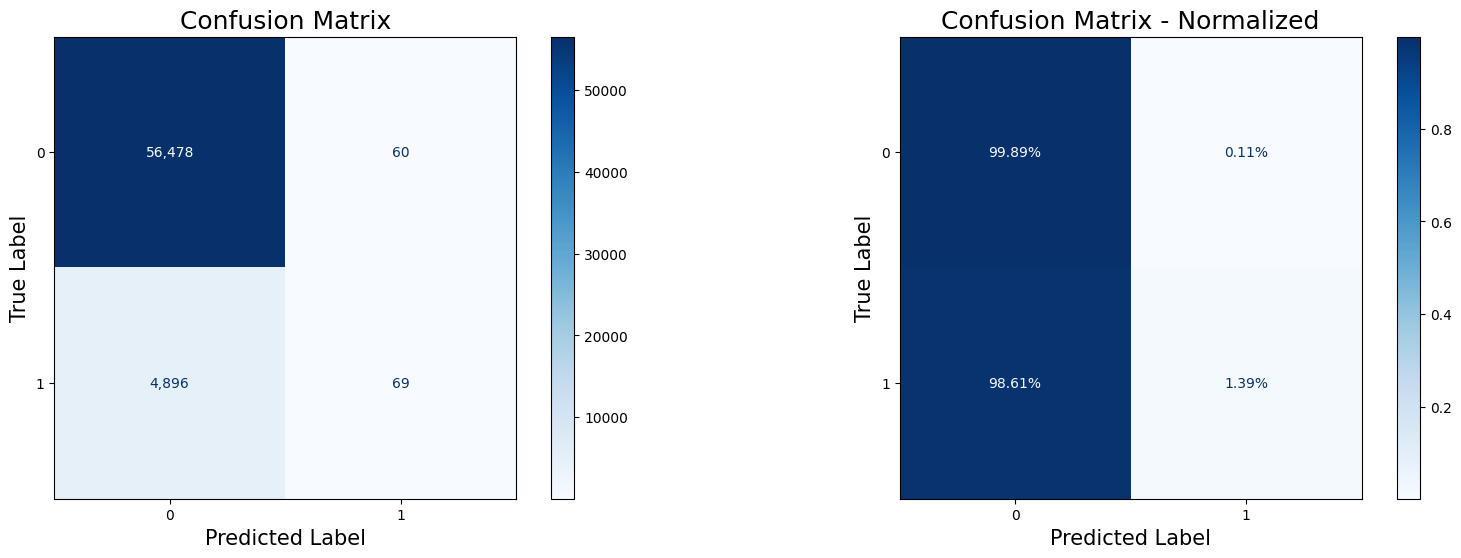

In [14]:
# Evaluamos cada clasificador
# ==============================================================================
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_scaled_t, y_train)

    y_pred = pipe.predict(X_test_scaled_t)
    y_true = y_test  
    
    # Mostrar resultados
    print("==============================================================================")
    print(f"\nClassifier: {classifier}")
    print(f"Model Score: {pipe.score(X_test_scaled_t, y_test):.3f}")
    
    funciones.evaluate_model(y_true, y_pred)
    print("==============================================================================")

Antes de hablar sobre qué modelo es el mejor, es importante tener en cuenta algo clave: cuando tenemos datos desbalanceados, la precisión no siempre es una buena métrica.

Un modelo podría tener una precisión alta simplemente prediciendo la clase mayoritaria, pero fallaría al identificar la clase minoritaria, que es la más relevante en este caso. El objetivo de este proyecto es ayudar al banco a tomar mejores decisiones al aprobar préstamos, por lo que necesitamos tener un buen rendimiento tanto en clientes solventes como en aquellos con dificultades de pago.

Para entender esto, necesitamos ver la matriz de confusión, que tiene cuatro partes esenciales:

- Verdaderos positivos: clientes solventes cuyos préstamos se aprueban. 
    
    
- Verdaderos negativos: clientes problemáticos cuyos préstamos se deniegan.  
    
    
- Falsos positivos: clientes con dificultades de pago a quienes se les aprueba el préstamo.
    
    
- Falsos negativos: clientes solventes cuyos préstamos se rechazan.

    
Es crucial prestar atención a los falsos positivos, porque aprobar préstamos a clientes problemáticos puede generar pérdidas económicas importantes para el banco. Aunque los falsos negativos no siempre implican pérdidas directas, sí afectan la eficiencia del proceso y pueden representar oportunidades perdidas.

En resumen, dado que tenemos un dataset desbalanceado, necesitamos métricas como recall, F1-Score y AUC-ROC, que ofrecen una visión más realista del rendimiento del modelo en ambas clases. También es útil analizar la matriz de confusión y considerar el impacto económico de los errores, para asegurar decisiones más efectivas y rentables que fortalezcan la estabilidad y rentabilidad del banco.

Si trabajamos con el dataset sin abordar el desequilibrio entre clases, no podremos determinar qué modelo es el mejor para resolver este problema. La mayoría de los modelos no superan al modelo básico Dummy. Por ejemplo, el Decision Tree Classifier identifica mejor a los verdaderos negativos, pero su recall sigue siendo bajo, lo que significa que no detecta bien a todos los clientes problemáticos.

Por otro lado, el único modelo que podemos descartar sin duda es el GaussianNB, ya que tiene demasiados falsos positivos, lo que podría generar problemas graves para las decisiones del banco.

Por eso, la idea es probar todos estos modelos después de tratar el desequilibrio en la muestra. Cabe mencionar que los datos utilizados para ajustar el desequilibrio se generan de forma ficticia, por lo que es necesario ser cauteloso al interpretar los resultados y al evaluar el desempeño del modelo.


## Balanceo de datos:

Como acabamos de mencionar, balanceamos los datos para que los modelos puedan aprender de forma más justa y no estén sesgados hacia las clases más comunes. Así, el rendimiento será más fiable y podremos detectar mejor a los clientes con problemas financieros.

He probado varias proporciones de balanceo, y en este notebook muestro solo dos. Sin embargo, experimenté con otras también. Lo interesante es que, en esta práctica, la calidad de los modelos no mejora cuando el ratio de clientes que no pagan supera el 35%.

In [15]:
# Proporción deseada final
# ==============================================================================
desired_ratio = 0.25 
final_sampling_strategy = desired_ratio / (1 - desired_ratio)  

In [16]:
# Aplicamos SMOTE + RandomUnderSampler
# ==============================================================================
smote = SMOTE(sampling_strategy=final_sampling_strategy, random_state=seed)
undersampler = RandomUnderSampler(sampling_strategy=final_sampling_strategy, random_state=seed)

In [17]:
# Oversampling con SMOTE
# ==============================================================================
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_t, y_train)

# Undersampling en la clase mayoritaria
# ==============================================================================
X_train_combined, y_train_combined = undersampler.fit_resample(X_train_smote, y_train_smote)


Classifier: RandomForestClassifier()
Model Score: 0.915

    Accuracy: 0.91461
    Balanced Accuracy: 0.52263
    F2 score: 0.06620
    F1 score: 0.09448
    Precision: 0.32814
    Recall: 0.05519
    


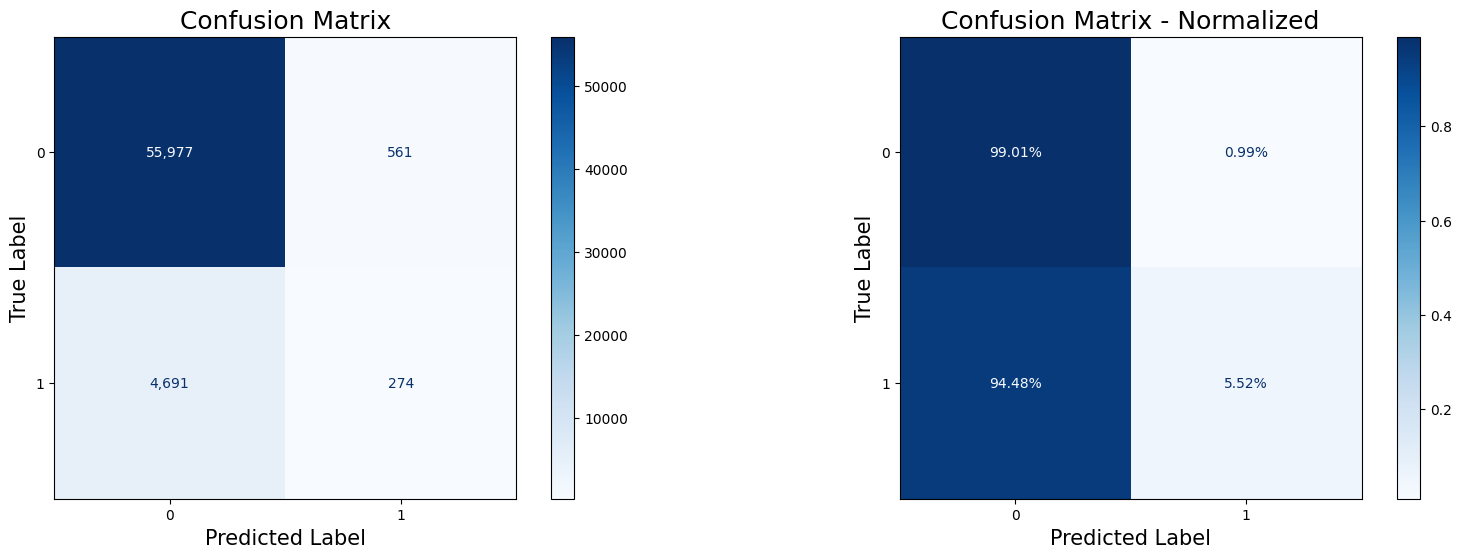


Classifier: GradientBoostingClassifier()
Model Score: 0.919

    Accuracy: 0.91896
    Balanced Accuracy: 0.51159
    F2 score: 0.03179
    F1 score: 0.04885
    Precision: 0.46545
    Recall: 0.02578
    


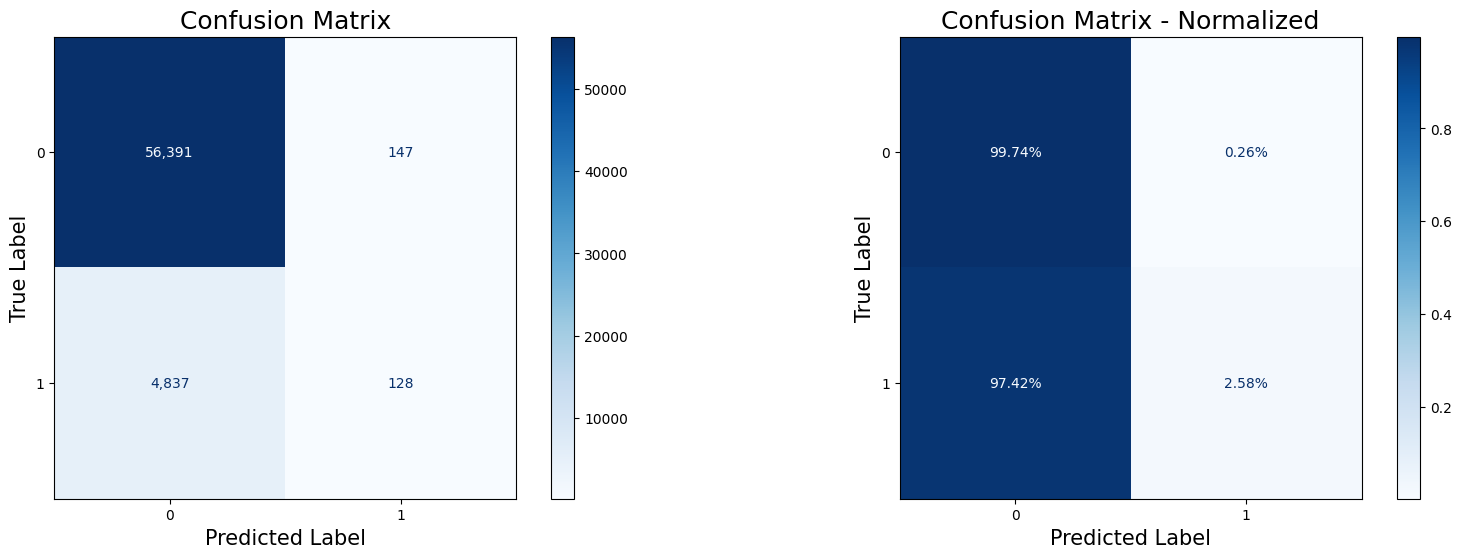


Classifier: AdaBoostClassifier()
Model Score: 0.899

    Accuracy: 0.89900
    Balanced Accuracy: 0.54482
    F2 score: 0.13618
    F1 score: 0.16370
    Precision: 0.24685
    Recall: 0.12246
    


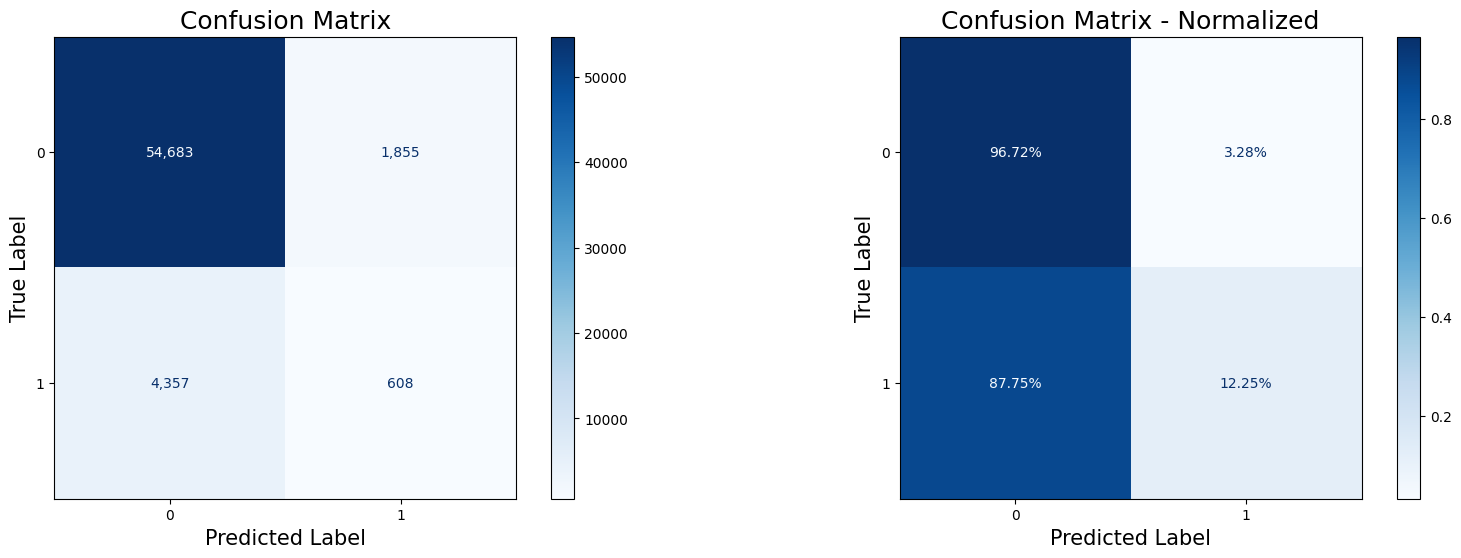


Classifier: LogisticRegression()
Model Score: 0.874

    Accuracy: 0.87414
    Balanced Accuracy: 0.59230
    F2 score: 0.25258
    F1 score: 0.24735
    Precision: 0.23910
    Recall: 0.25619
    


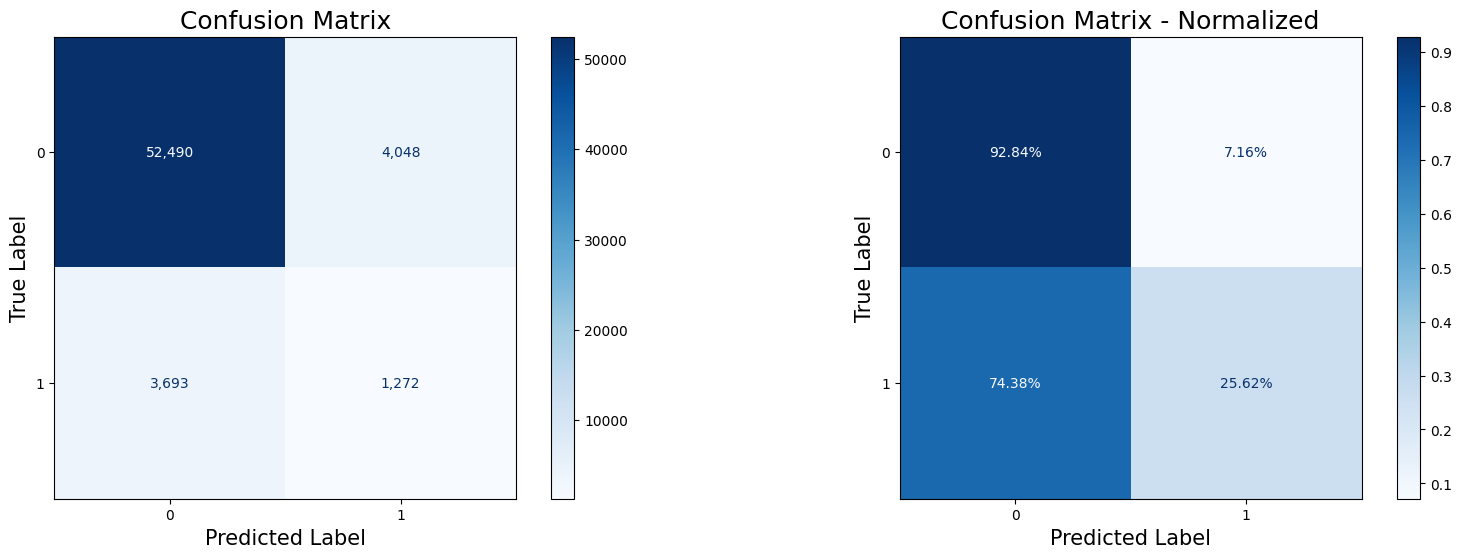


Classifier: GaussianNB()
Model Score: 0.919

    Accuracy: 0.91927
    Balanced Accuracy: 0.50000
    F2 score: 0.00000
    F1 score: 0.00000
    Precision: 0.00000
    Recall: 0.00000
    


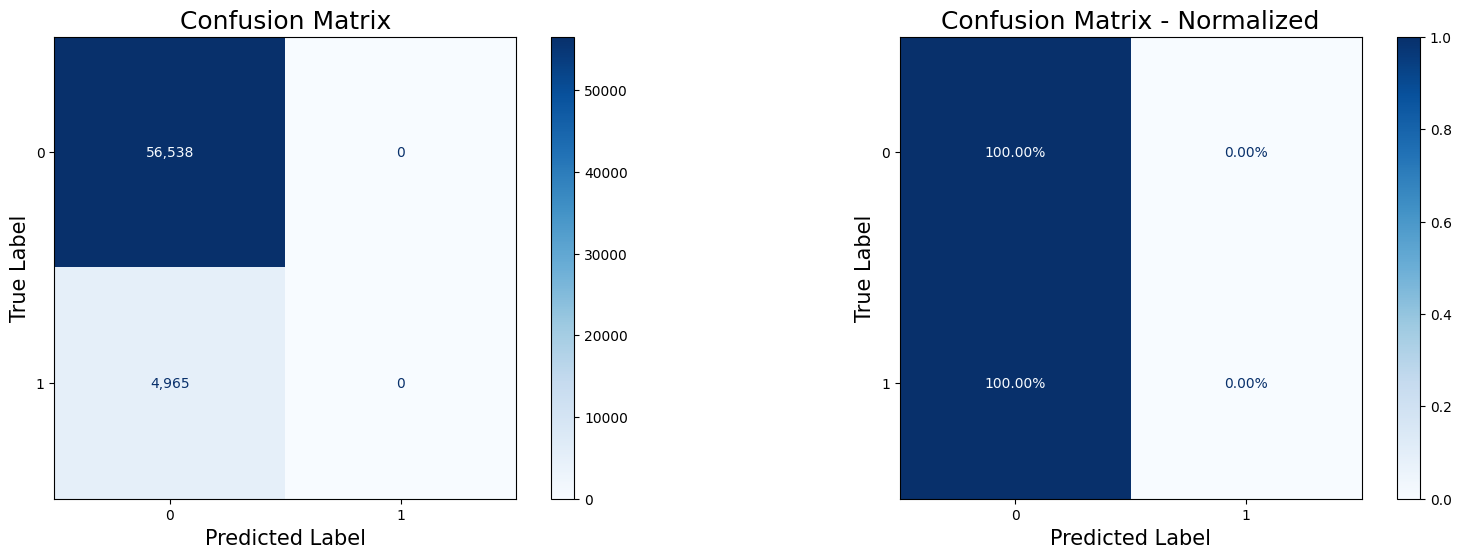


Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Model Score: 0.830

    Accuracy: 0.83022
    Balanced Accuracy: 0.59716
    F2 score: 0.27800
    F1 score: 0.23288
    Precision: 0.18330
    Recall: 0.31923
    


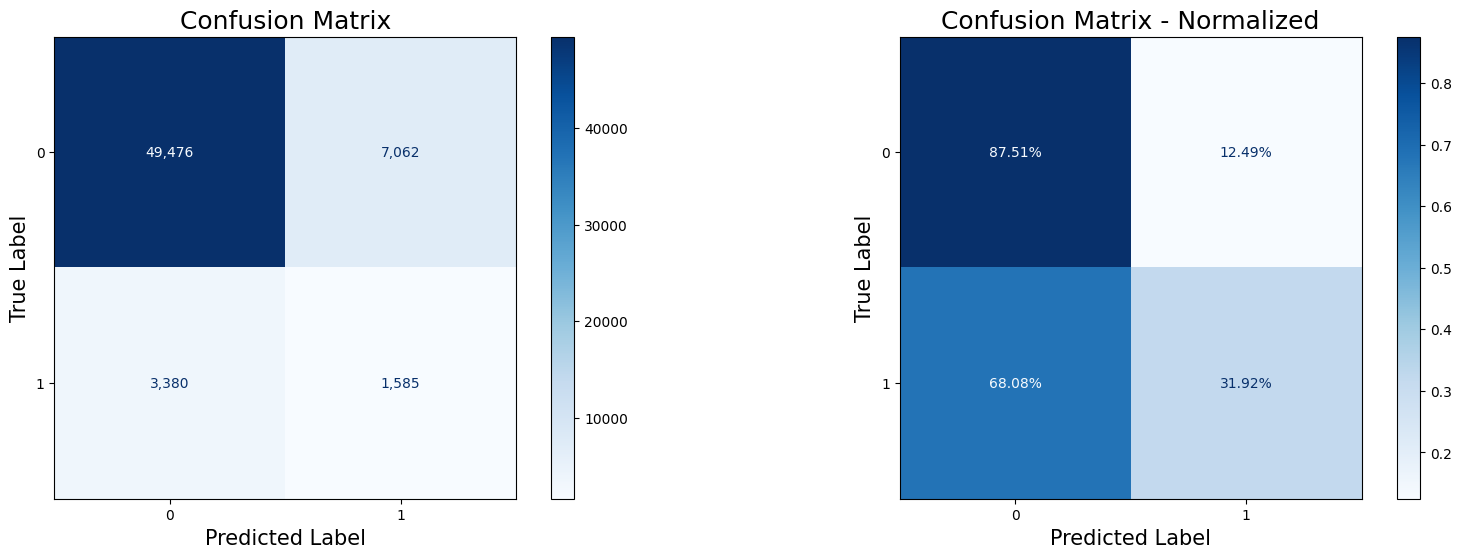

[LightGBM] [Info] Number of positive: 75382, number of negative: 226146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4260
[LightGBM] [Info] Number of data points in the train set: 301528, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612

Classifier: LGBMClassifier()
Model Score: 0.912

    Accuracy: 0.91235
    Balanced Accuracy: 0.52636
    F2 score: 0.07831
    F1 score: 0.10848
    Precision: 0.30314
    Recall: 0.06606
    


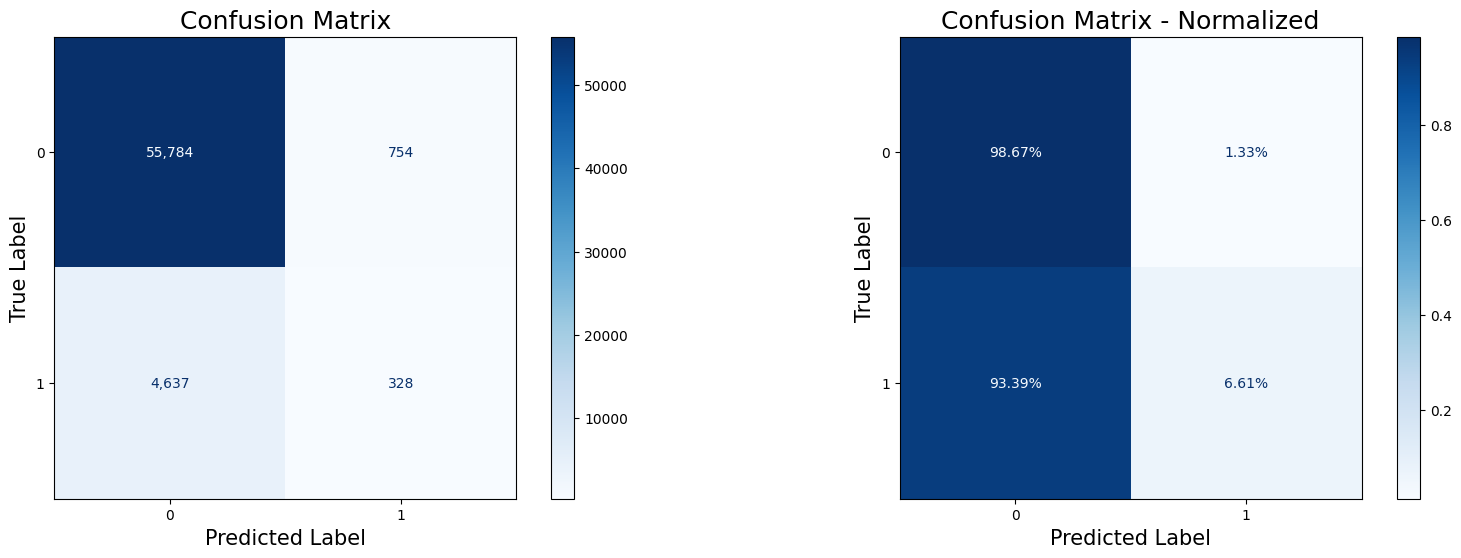


Classifier: DecisionTreeClassifier()
Model Score: 0.804

    Accuracy: 0.80370
    Balanced Accuracy: 0.53506
    F2 score: 0.18316
    F1 score: 0.15009
    Precision: 0.11537
    Recall: 0.21470
    


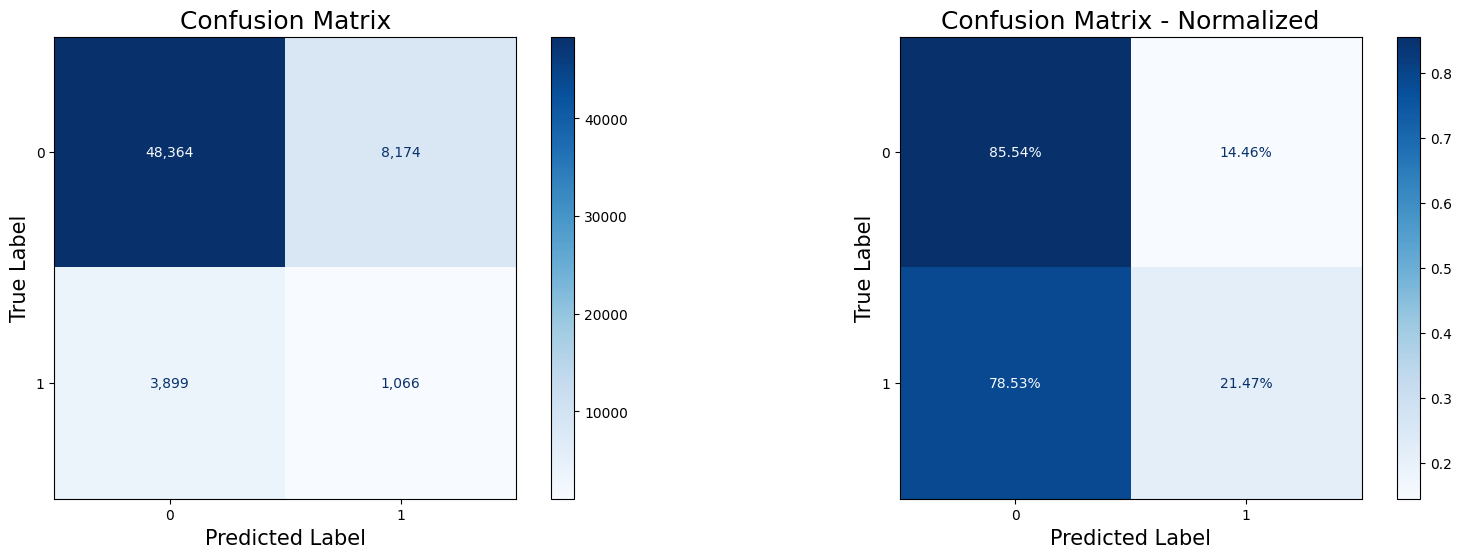


Classifier: ExtraTreesClassifier()
Model Score: 0.918

    Accuracy: 0.91818
    Balanced Accuracy: 0.50887
    F2 score: 0.02558
    F1 score: 0.03933
    Precision: 0.37729
    Recall: 0.02075
    


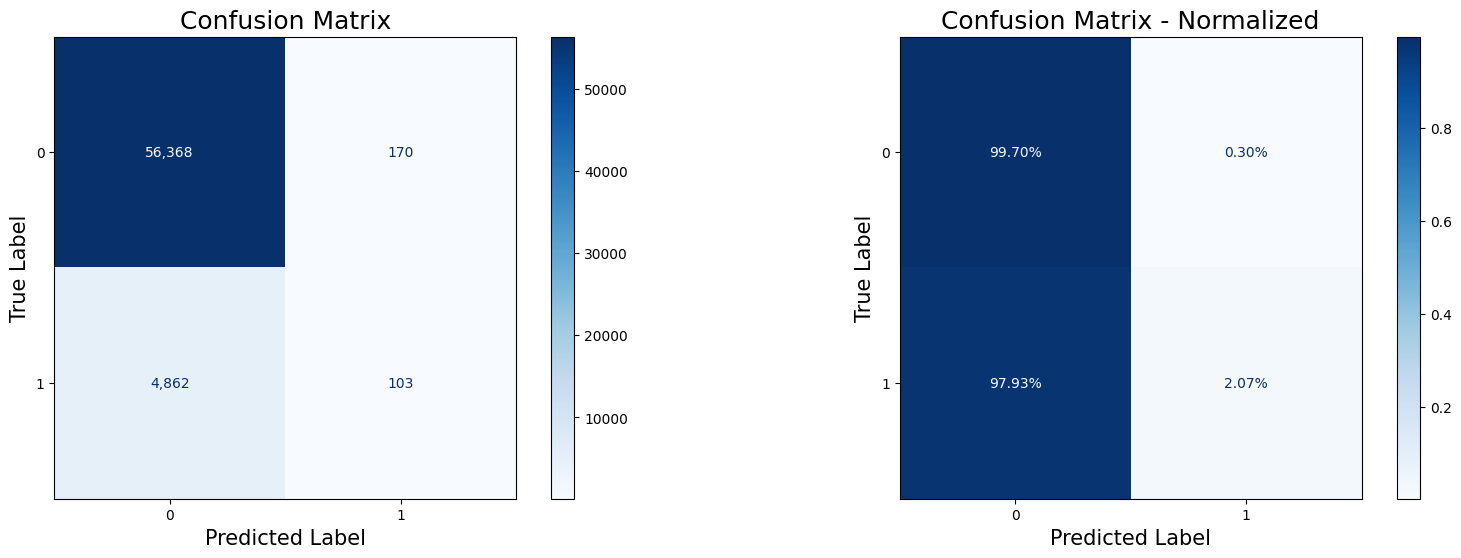

In [19]:
# Evaluamos cada clasificador
# ==============================================================================
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_combined, y_train_combined)

    y_pred = pipe.predict(X_test_scaled_t)
    y_true = y_test  
    
    # Mostrar resultados
    print("==============================================================================")
    print(f"\nClassifier: {classifier}")
    print(f"Model Score: {pipe.score(X_test_scaled_t, y_test):.3f}")
    
    funciones.evaluate_model(y_true, y_pred)
    print("==============================================================================")

In [20]:
# Proporción deseada final
# ==============================================================================
desired_ratio = 0.35
final_sampling_strategy = desired_ratio / (1 - desired_ratio) 

In [21]:
# Aplicamos SMOTE + RandomUnderSampler
# ==============================================================================
smote = SMOTE(sampling_strategy=final_sampling_strategy, random_state=seed)
undersampler = RandomUnderSampler(sampling_strategy=final_sampling_strategy, random_state=seed)

In [22]:
# Oversampling con SMOTE
# ==============================================================================
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_t, y_train)

# Undersampling en la clase mayoritaria
# ==============================================================================
X_train_combined, y_train_combined = undersampler.fit_resample(X_train_smote, y_train_smote)


Classifier: RandomForestClassifier()
Model Score: 0.904

    Accuracy: 0.90373
    Balanced Accuracy: 0.53086
    F2 score: 0.09874
    F1 score: 0.12631
    Precision: 0.23620
    Recall: 0.08620
    


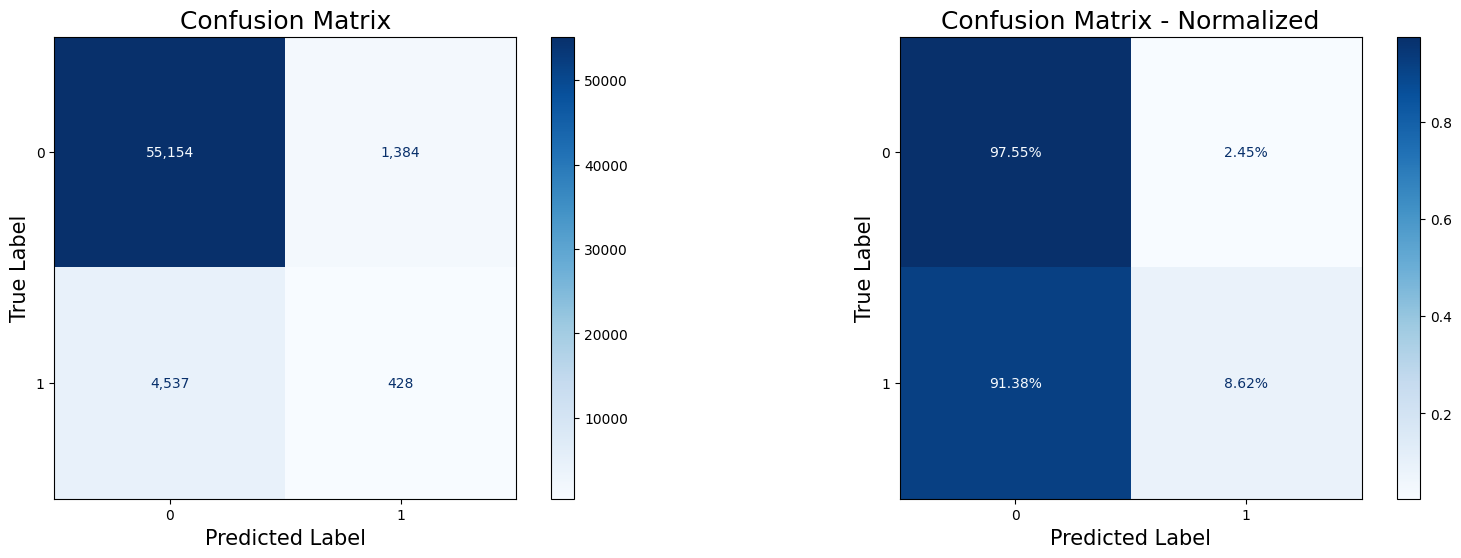


Classifier: GradientBoostingClassifier()
Model Score: 0.913

    Accuracy: 0.91254
    Balanced Accuracy: 0.52711
    F2 score: 0.07998
    F1 score: 0.11076
    Precision: 0.30904
    Recall: 0.06747
    


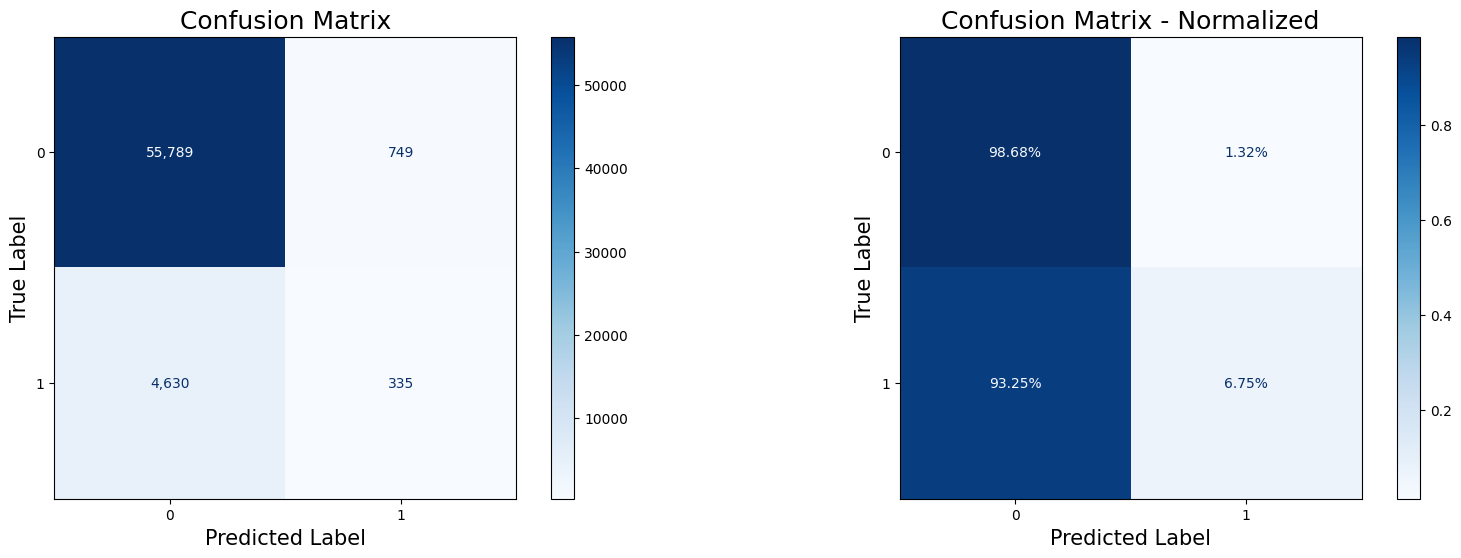


Classifier: AdaBoostClassifier()
Model Score: 0.867

    Accuracy: 0.86695
    Balanced Accuracy: 0.56781
    F2 score: 0.20815
    F1 score: 0.20391
    Precision: 0.19721
    Recall: 0.21108
    


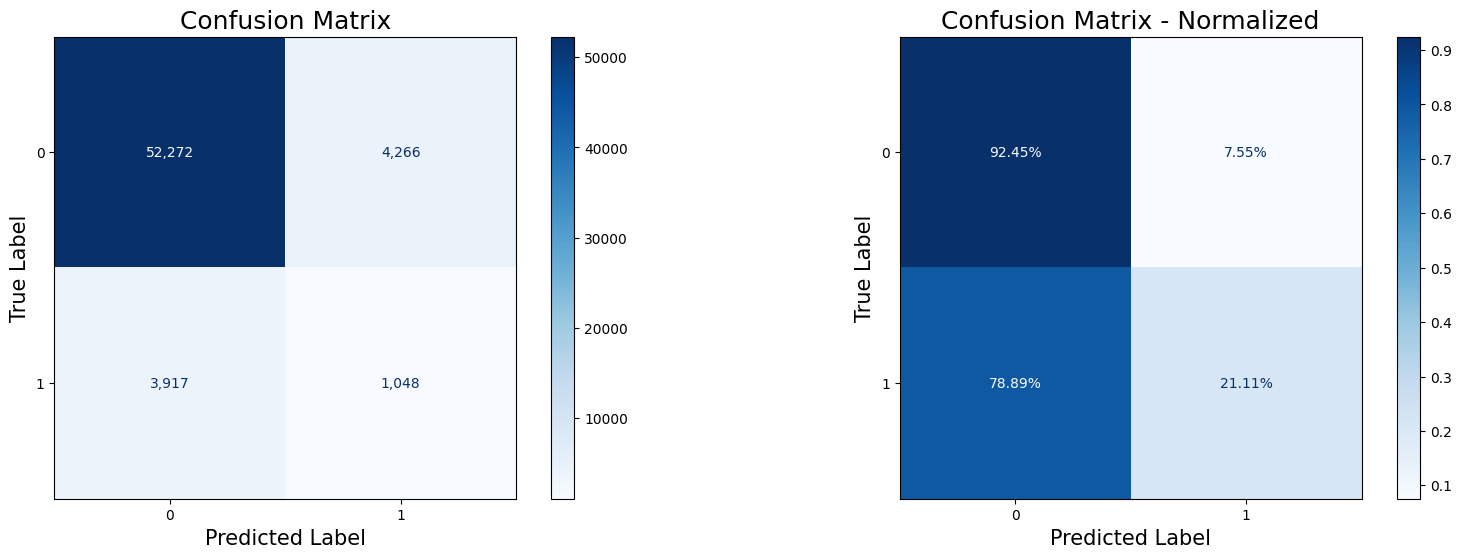


Classifier: LogisticRegression()
Model Score: 0.798

    Accuracy: 0.79829
    Balanced Accuracy: 0.64740
    F2 score: 0.36330
    F1 score: 0.27229
    Precision: 0.19209
    Recall: 0.46747
    


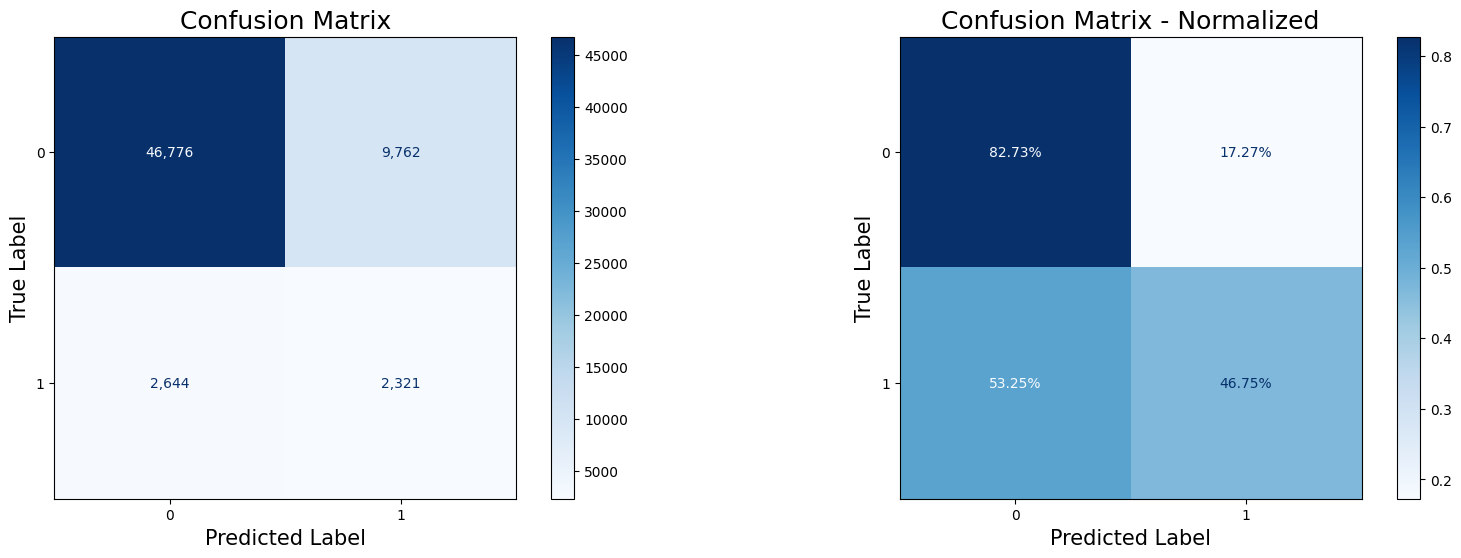


Classifier: GaussianNB()
Model Score: 0.919

    Accuracy: 0.91914
    Balanced Accuracy: 0.50204
    F2 score: 0.00577
    F1 score: 0.00917
    Precision: 0.42593
    Recall: 0.00463
    


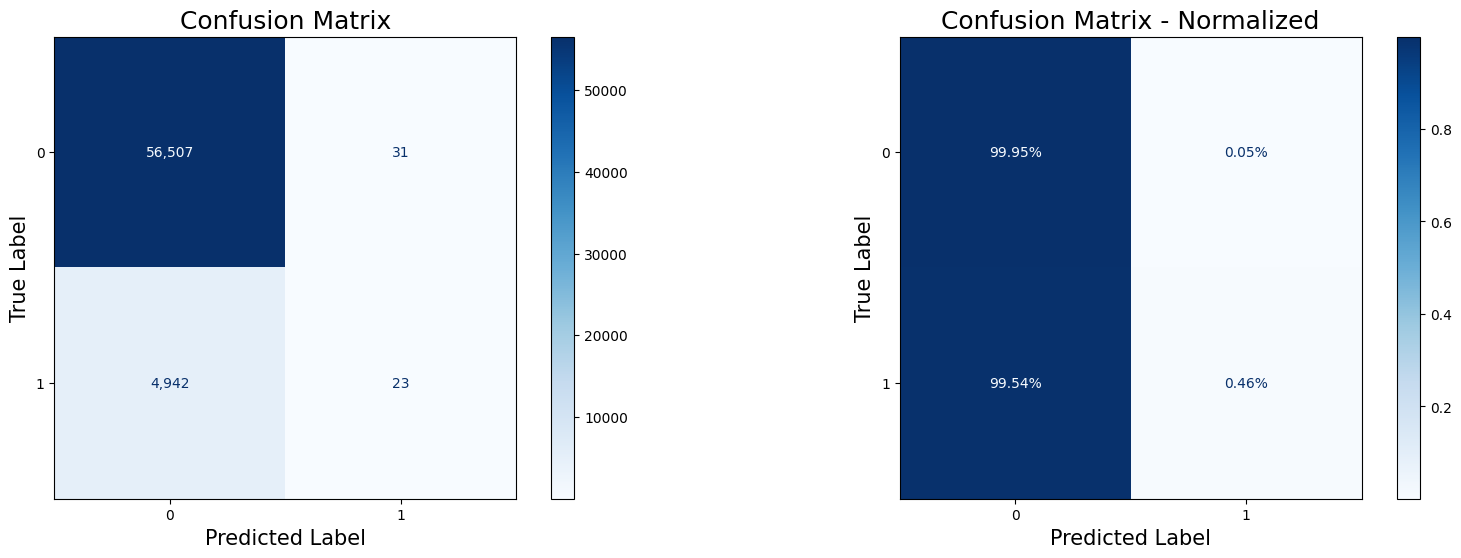


Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Model Score: 0.780

    Accuracy: 0.78045
    Balanced Accuracy: 0.61850
    F2 score: 0.32371
    F1 score: 0.23828
    Precision: 0.16549
    Recall: 0.42538
    


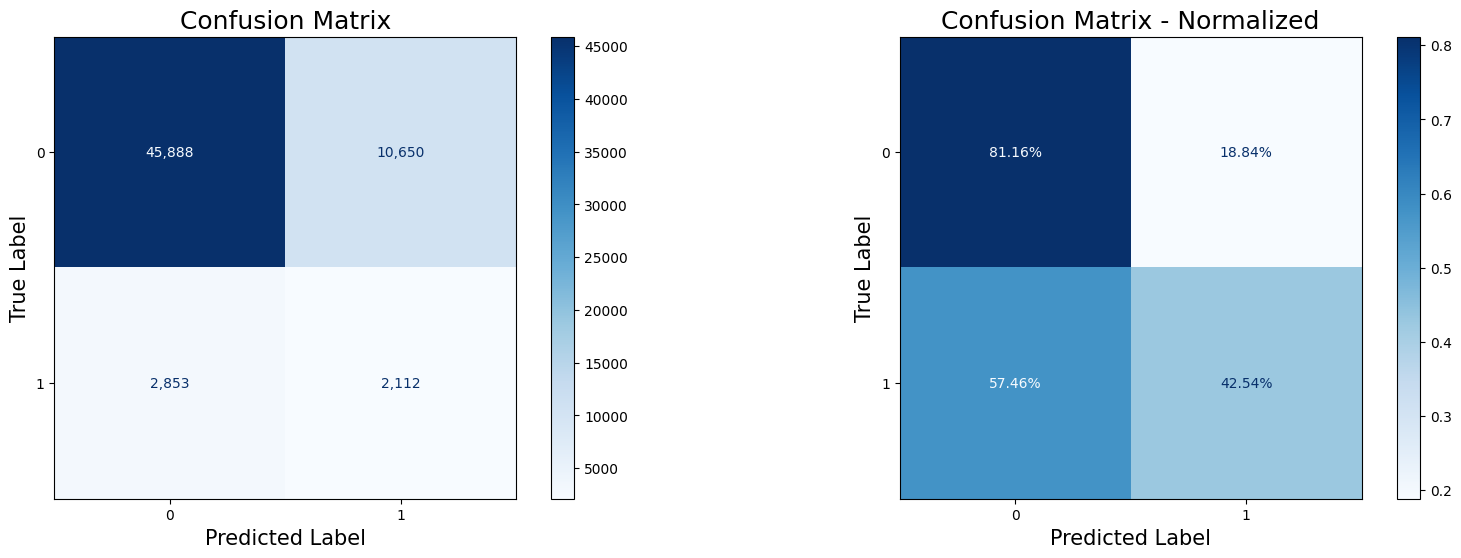

[LightGBM] [Info] Number of positive: 121772, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4291
[LightGBM] [Info] Number of data points in the train set: 347920, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350000 -> initscore=-0.619039
[LightGBM] [Info] Start training from score -0.619039

Classifier: LGBMClassifier()
Model Score: 0.907

    Accuracy: 0.90696
    Balanced Accuracy: 0.53703
    F2 score: 0.11034
    F1 score: 0.14264
    Precision: 0.27853
    Recall: 0.09587
    


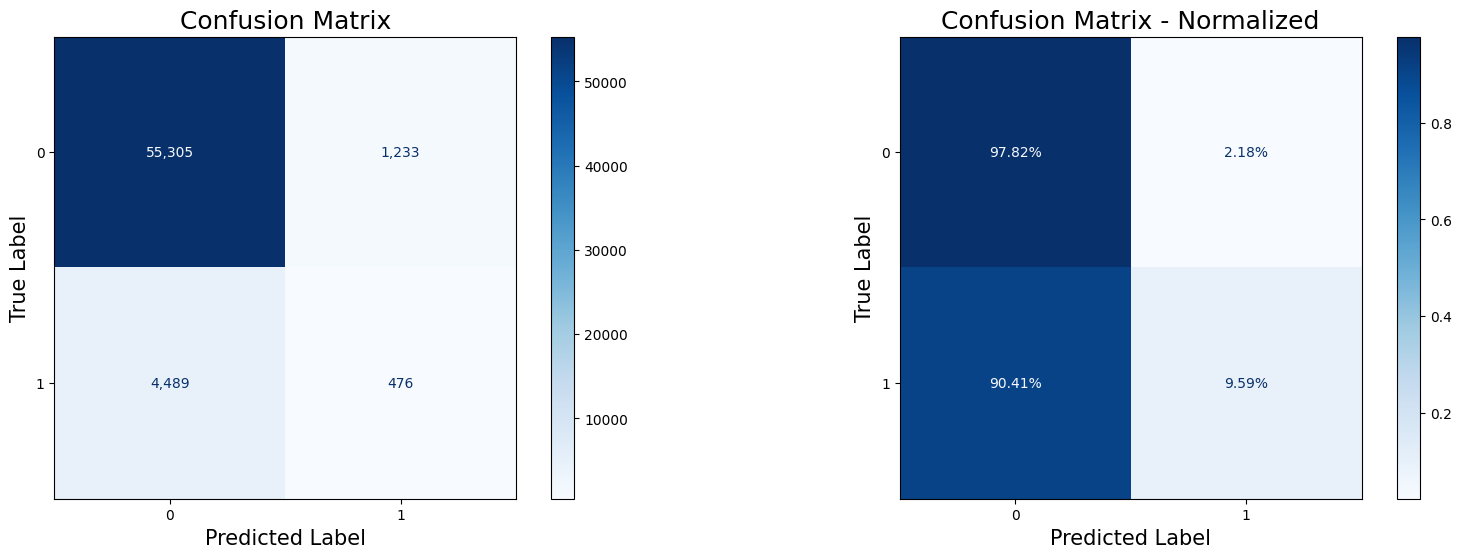


Classifier: DecisionTreeClassifier()
Model Score: 0.788

    Accuracy: 0.78775
    Balanced Accuracy: 0.54945
    F2 score: 0.21532
    F1 score: 0.16790
    Precision: 0.12282
    Recall: 0.26526
    


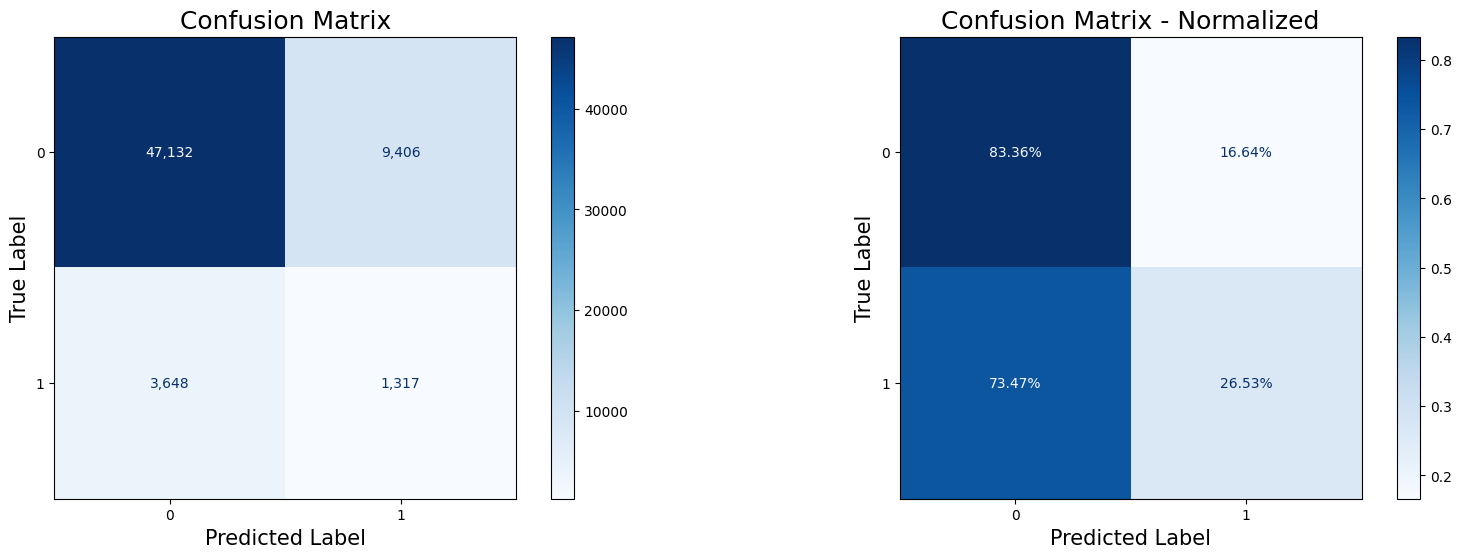


Classifier: ExtraTreesClassifier()
Model Score: 0.917

    Accuracy: 0.91656
    Balanced Accuracy: 0.51276
    F2 score: 0.03811
    F1 score: 0.05696
    Precision: 0.32495
    Recall: 0.03122
    


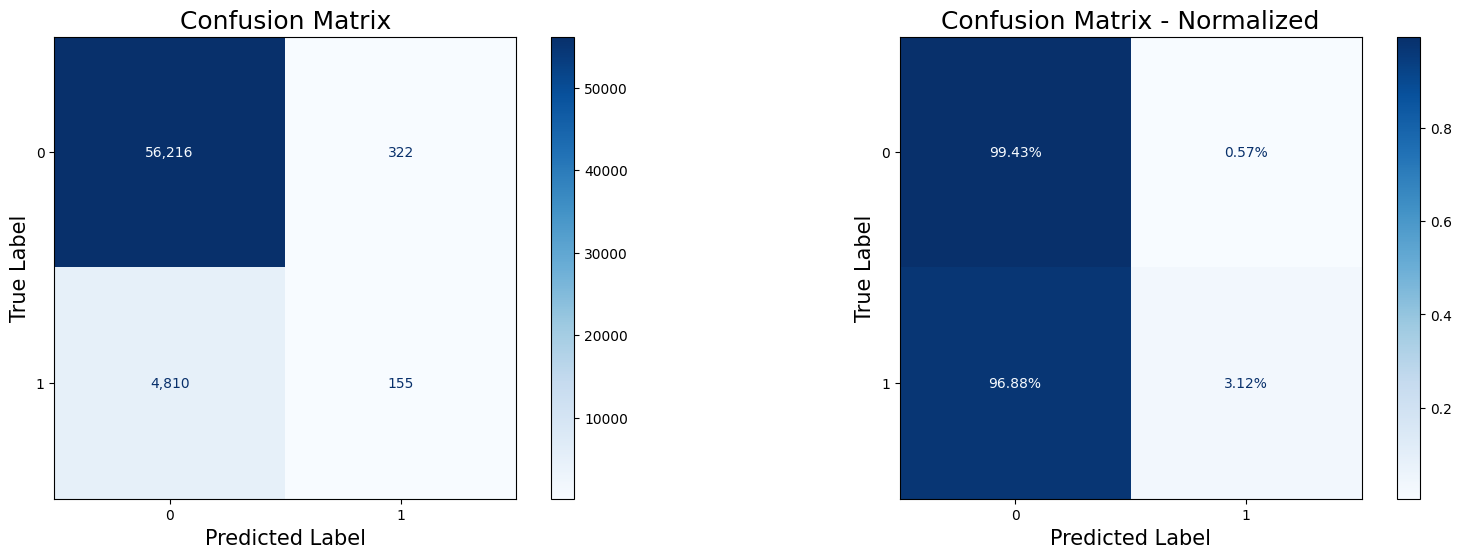

In [23]:
# Evaluamos cada clasificador
# ==============================================================================
for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_combined, y_train_combined)

    y_pred = pipe.predict(X_test_scaled_t)
    y_true = y_test  
    
    # Mostrar resultados
    print("==============================================================================")
    print(f"\nClassifier: {classifier}")
    print(f"Model Score: {pipe.score(X_test_scaled_t, y_test):.3f}")
    
    funciones.evaluate_model(y_true, y_pred)
    print("==============================================================================")

Después de algunas pruebas, podemos ver que el balanceo de datos mejora bastante el desempeño de los modelos. De las dos proporciones que he mostrado, me quedo con la segunda, que simula un escenario donde el 35% de los clientes no paga el préstamo. Es crucial tener en cuenta los falsos positivos, ya que aprobar préstamos a clientes problemáticos puede resultar en pérdidas económicas importantes para el banco.

De todos los modelos que he probado, destaco la regresión logística y el XGBoost, ya que son los que mejor rendimiento tienen. Los demás no dan buenos resultados. Por ejemplo, el Random Forest y el ExtraTrees tienen métricas bastante bajas y no logran captar bien lo que está pasando en los datos.

Modelos como el Gradient Boosting y el AdaBoost también tienen problemas para ajustarse al dataset y no mejoran mucho en precisión y recall. Además, algunos de estos enfoques más complejos tienden a sobreajustarse y no son lo suficientemente robustos para este caso. Por eso, creo que la regresión logística y el XGBoost son las mejores opciones para este proyecto.

Teniendo en mente el objetivo principal del proyecto, he decidido quedarme con el modelo de regresión logística. Aunque es cierto que no predice con total exactitud a los clientes que generan impagos y, por ende, pérdidas, sí logra identificar con mucha precisión a aquellos que cumplen con el pago de sus préstamos. Este modelo podría ser útil, por ejemplo, para aumentar la cantidad de clientes del banco, incluso si esto supone asumir más riesgos en términos de rentabilidad.

Dicho esto, es importante considerar que este modelo sería beneficioso en un enfoque más arriesgado. Si el objetivo fuera adoptar una postura más conservadora—priorizando la rentabilidad y mejorando la detección de clientes que no pagan—sería necesario explorar otras opciones y seleccionar un modelo más adecuado para esa estrategia. Por esta razón, creo que sería muy útil crear una matriz de confusión con costos, que refleje el impacto económico de cada tipo de error. Por ejemplo, un falso positivo podría tener un costo mayor que un falso negativo dependiendo del contexto del negocio. Sin embargo, como no tenemos la opción de definir estos costos para este caso en particular, no he podido generar dicha matriz.

## Hiperparámetros:

Una vez que elegimos nuestro modelo, el siguiente paso es optimizar los hiperparámetros. Estos son parámetros que no se aprenden de los datos y tenemos que definirlos nosotros mismos. Su impacto en los resultados puede ser enorme, pero no hay una fórmula mágica para saber cuáles son los mejores, así que toca probar diferentes valores. Aunque no tengo experiencia previa, me he apoyado en métodos conocidos para encontrar los mejores.

Hay dos maneras comunes de hacerlo: Grid Search y Random Search. Grid Search prueba todas las combinaciones posibles de hiperparámetros, pero puede ser lento y poco eficiente. En cambio, Random Search elige valores aleatorios dentro de un rango definido, explorando más rápido y cubriendo más opciones.

Para este caso, opté por usar Random Search porque es más eficiente al evaluar un número limitado de combinaciones aleatorias. Al final, ajusté el modelo con los mejores hiperparámetros y todos los datos de entrenamiento.

Hay que recordar que nuestro objetivo en la búsqueda de hiperparámetros es mejorar el recall y el F1 score del modelo, ya que queremos identificar correctamente a los clientes problemáticos sin dejar pasar demasiados casos positivos.

In [28]:
# Definir el modelo base
# ==============================================================================
log_reg = LogisticRegression(random_state=seed)

# Espacio de búsqueda de hiperparámetros 
# ==============================================================================
param_grid = {
    'penalty': ['l1', 'l2'],              
    'C': np.logspace(-2, 2, 5),           
    'solver': ['liblinear'],              
    'max_iter': [100, 200]               
}

# Métrica de evaluación
# ==============================================================================
scoring = make_scorer(f1_score, average='weighted')

# Configuración del RandomizedSearchCV
# ==============================================================================
CV_log = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_grid,
    n_iter=20,              
    scoring=scoring,         
    cv=3,                    
    random_state=seed,
    n_jobs=-1               
)

In [29]:
# Entrenamiento del modelo
# ==============================================================================
CV_log.fit(X_train_combined, y_train_combined)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'max_iter': [100, 200],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [30]:
# Resultados
# ==============================================================================
print("Mejores Hiperparámetros:")
print(CV_log.best_params_)
print()
print(f"Mejor F1 Score (Weighted): {CV_log.best_score_:.4f}")

Mejores Hiperparámetros:
{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 1.0}

Mejor F1 Score (Weighted): 0.6890


# Modelo final:

Una vez que hemos seleccionado y optimizado los hiperparámetros del modelo, llega el momento de evaluarlo en profundidad. Para esto, vamos a analizar diversas métricas y representaciones visuales, como la matriz de confusión (tanto normalizada como sin normalizar), la curva ROC, la curva de ganancia y la curva de precisión-recall, entre otras. El objetivo es tener una visión clara del desempeño del modelo para poder desplegarlo en producción con la confianza de que funcionará de manera robusta y eficiente en escenarios del mundo real.

In [31]:
# Definir el modelo con los mejores hiperparámetros
# ==============================================================================
log_reg = LogisticRegression(
    solver='liblinear', 
    penalty='l1', 
    max_iter=100, 
    C=0.1
)

log_reg.fit(X_train_combined, y_train_combined)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [32]:
# Predicciones del modelo
# ==============================================================================
y_pred = log_reg.predict(X_test_scaled_t)

In [33]:
# Probabilidades de predicciones del modelo
# ==============================================================================
prob_predictions = log_reg.predict_proba(X_test_scaled_t)

In [34]:
# Mostramos el reporte de clasificación 
# ==============================================================================
print("Classification Report: \n")
print(classification_report(y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     56538
           1       0.21      0.44      0.28      4965

    accuracy                           0.82     61503
   macro avg       0.58      0.65      0.59     61503
weighted avg       0.89      0.82      0.85     61503



El modelo tiene un buen rendimiento al identificar a los clientes que pagan sus préstamos, aunque no es tan efectivo con la clase de clientes problemáticos. Sin embargo, como mencionamos antes, este modelo podría ser útil para, por ejemplo, aumentar la base de clientes del banco. El informe proporciona una visión clara de cómo el modelo está aprendiendo de los datos y qué áreas podrían mejorarse para optimizar su desempeño.

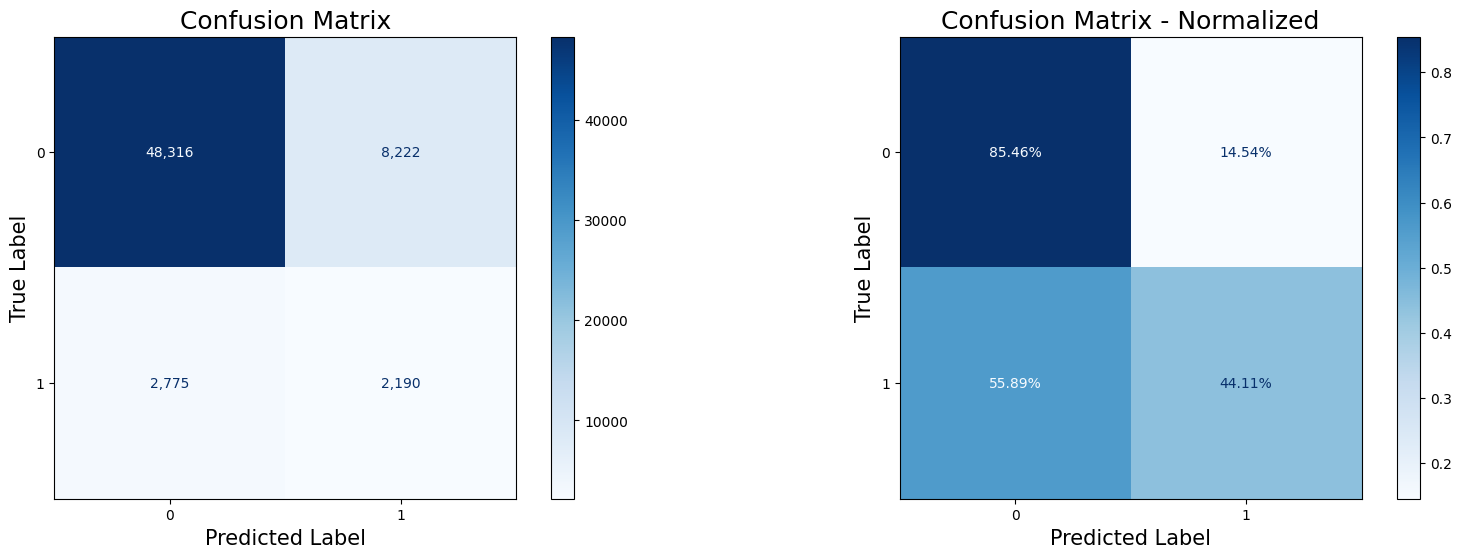

In [35]:
# Pintar matriz de confusión
# ==============================================================================
funciones.plot_cmatrix(y_test, y_pred)

Nuestro modelo no predice del todo bien la clase minoritaria, pero sí hace un buen trabajo con la clase mayoritaria. Lo importante es que el modelo esté alineado con los objetivos del banco, y por ahora, puede servir como una buena primera aproximación.

## Curva ROC:

La curva ROC es una gráfica que compara cuántos falsos positivos y verdaderos positivos tiene nuestro modelo. Básicamente, muestra qué tan bien tu modelo puede separar las clases de clientes que pagan y no pagan los prestamos bancarios. Además, el área bajo esta curva (AUC) es un buen indicador de qué tan bien lo está haciendo.

Por otro lado, el coeficiente de GINI también mide la calidad de tu modelo, pero de una forma más directa. Se calcula a partir del área bajo la curva ROC y te dice qué tan bien el modelo distingue entre las clases. Un valor más alto significa que tu modelo está separando mejor a los clientes problemáticos de los que pagan el préstamo.

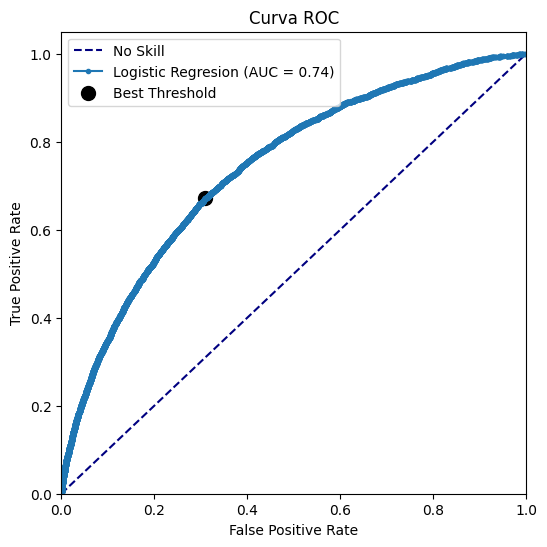


El coeficiente de GINI es: 0.48
El área bajo la curva ROC (AUC) es: 0.74
El mejor Threshold es 0.354, con G-Mean 0.681


0

In [36]:
# Dibujar curva ROC
# ==============================================================================
yhat = prob_predictions[:, 1]
funciones.plot_roc_gini(y_test,yhat)

El coeficiente de GINI y el área bajo la curva ROC indican que el modelo tiene buena capacidad para diferenciar entre clientes que pagan y clientes problemáticos. Sin embargo, es importante tener en cuenta que estos resultados están algo sesgados debido al desbalance en la muestra.

En la curva ROC podemos ver además el mejor threshold. Este threshold es el punto en el que se logra la mejor combinación entre la mayor cantidad de verdaderos positivos y la menor cantidad de falsos positivos. A partir de aquí, podemos ajustar los umbrales y observar cómo varía el resultado en la matriz de confusión.

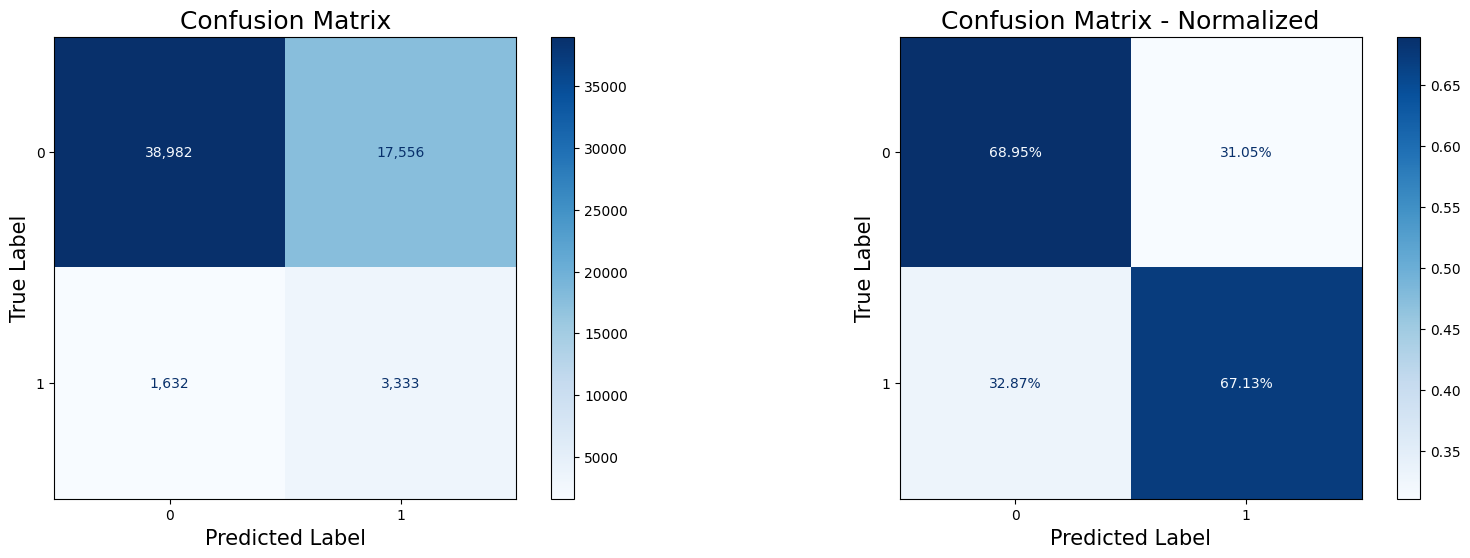

In [37]:
# Matriz de confusión con el nuevo umbral
# ==============================================================================
binary_predictions = np.where(prob_predictions > 0.354, 1, 0)
yhat_roc = binary_predictions[:, 1]
yhat_roc

funciones.plot_cmatrix(y_test, yhat_roc)

Al cambiar el umbral, el modelo mejora en clasificar tanto la clase mayoritaria como la minoritaria. Esto deja claro que, según lo que busquemos, ajustaremos el umbral para las probabilidades que nos da el modelo.

## Curva precision-recall:

La curva precision-recall muestra cómo tu modelo equilibra dos métricas clave: precision y recall. La precision indica cuántos de los clientes identificados como clientes que realmente pagan, mientras que el recall muestra cuántos clientes que pagan realmente fueron detectados por el modelo.

Esta curva es especialmente útil cuando las clases están desbalanceadas, como es nuestro caso, ya que te da una visión más clara de cómo el modelo está capturando patrones clave y evitando errores.

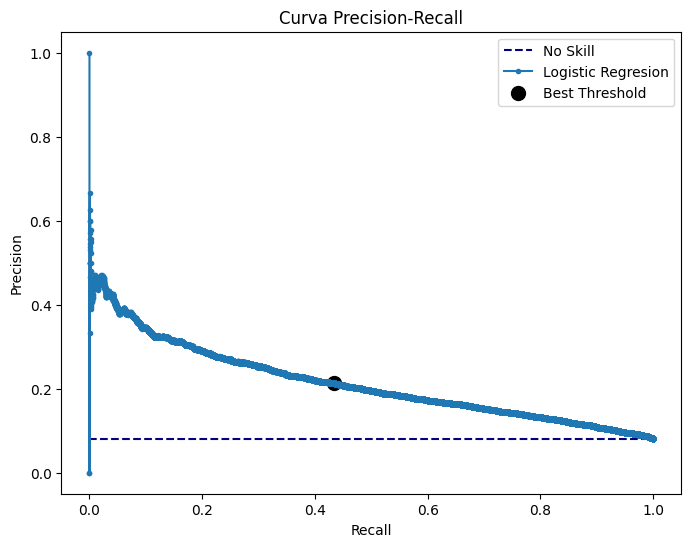


El mejor Threshold es 0.506, con F-Score 0.286


0

In [38]:
# Dibujar curva precision-recall
# ==============================================================================
funciones.plot_precision_recall(y_test,yhat)

El punto negro muestra el umbral ideal para conseguir el mejor F2 Score, que es una métrica importante para nuestro modelo. Al ajustar el F2, buscamos un equilibrio entre precisión y recall, dando más importancia al recall, aunque eso signifique sacrificar algo de precisión. En este caso, el umbral es más alto, lo que mejora la precisión y hace que el F2 sea más equilibrado, aunque para nuestro modelo el recall sigue siendo lo más importante.

Eso sí, es bueno tener en cuenta que este ajuste podría hacer que se detecten menos fraudes en total. Pero desde un punto de vista práctico, es más eficiente porque optimiza el ratio entre cuántas investigaciones se necesitan y cuántos fraudes se identifican correctamente.

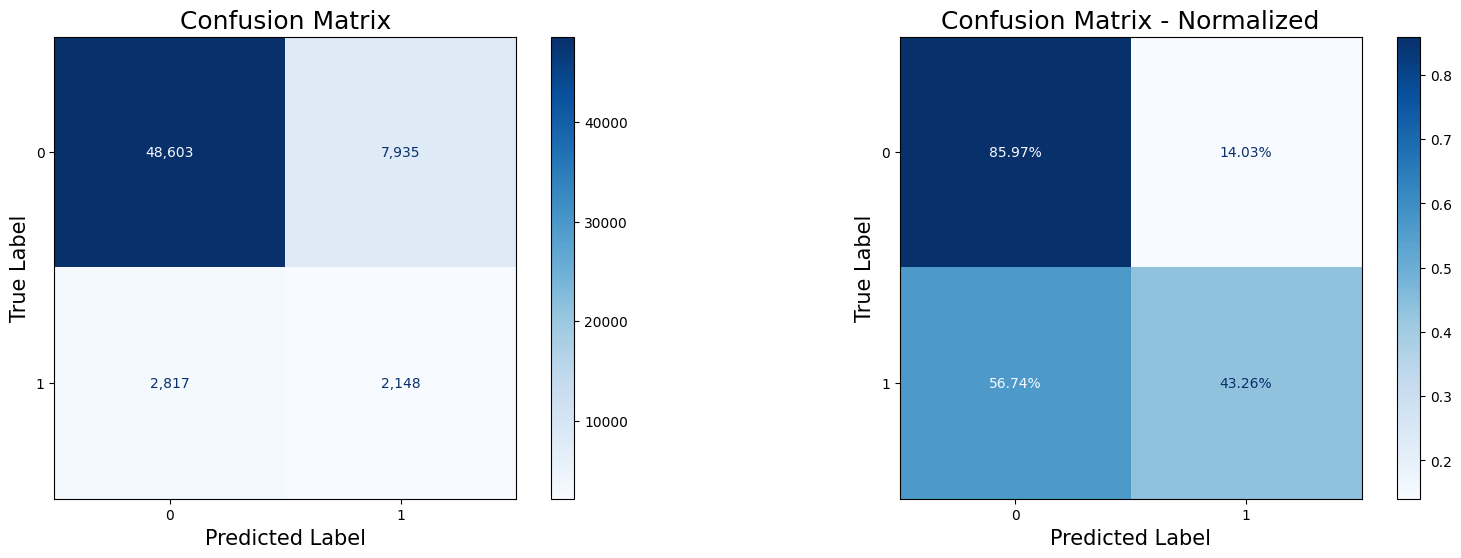

In [39]:
# Matriz de confusión con el nuevo umbral
# ==============================================================================
binary_predictions = np.where(prob_predictions > 0.506, 1, 0)
yhat_p_r = binary_predictions[:, 1]
yhat_p_r

funciones.plot_cmatrix(y_test, yhat_p_r)

En este caso, los resultados obtenidos son similares a los conseguidos con el umbral base, lo que nos indica que, aunque el nuevo umbral ideal maximiza el F2 Score, el modelo ya estaba cerca de un buen equilibrio y no se ve afectado significativamente por este ajuste.

## Curvas de ganancia y lift:

La curva de ganancia es un gráfico que muestra qué porcentaje de instancias de una clase en particular se detectan en diferentes porcentajes de la muestra total.

Para crearla, primero se ordenan las instancias de mayor a menor probabilidad. Luego, se calcula cuántas de esas instancias están correctamente clasificadas en una clase específica, comparándolas con el total de esa clase dentro del 10% con las puntuaciones más altas, luego en el 20%, y así sucesivamente hasta cubrir el 100% de la muestra.

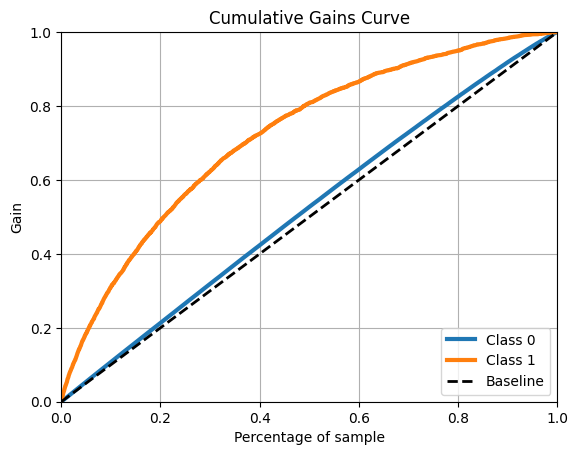

In [40]:
skplt.metrics.plot_cumulative_gain(y_test, prob_predictions)
plt.show()

La curva de ganancia muestra que con solo el 50% de los datos podemos detectar el 80% de los casos de fraude, lo que significa que podemos enfocarnos en una parte del conjunto de clientes y analizar solo lo necesario, sin tener que revisar todo el dataset completo. Esto hace que el proceso sea más eficiente y menos costoso.

Por otro lado, si la ordenación de probabilidades no aportara ningún valor, la curva estaría muy cerca de la diagonal, lo que indicaría que el modelo no es efectivo. Esto es lo que ocurre con la clase de pagadores, que se encuentra casi sobre esa línea diagonal. Este comportamiento es común en conjuntos de datos muy desbalanceados, como el nuestro, y coincide con el hecho de que el modelo base identifica bien los no fraudes, pero no mejora mucho más la detección de fraudes adicionales.

Por su lado, el gráfico de elevación, da una visión de cuán más probable es encontrar una clase en la muestra, frente a si escogiéramos el mismo porcentaje de población de forma aleatoria.

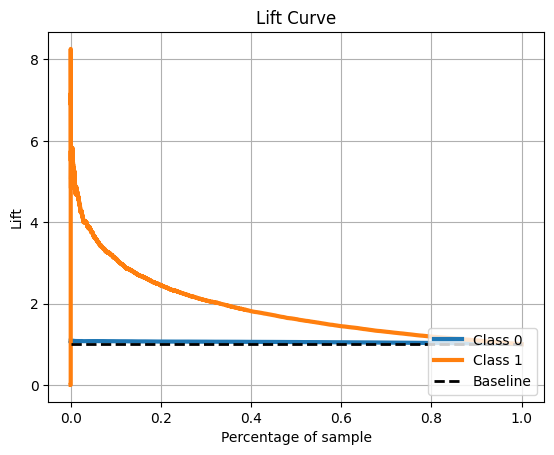

In [41]:
skplt.metrics.plot_lift_curve(y_test, prob_predictions)
plt.show()

En este caso, el gráfico muestra que si analizamos el 5% de los datos con mayor probabilidad según el modelo, es más de 8 veces más probable encontrar fraudes que si seleccionáramos ese 10% al azar. Esto demuestra que el modelo hace un buen trabajo priorizando los casos más importantes.

A medida que analizamos un porcentaje mayor de los datos, el Lift baja y se acerca a 1. Esto es normal, ya que, al incluir más datos, los resultados del modelo se parecen más a la proporción promedio de fraudes en el conjunto completo.

Por otro lado, para los no fraudes, la curva se mantiene cerca de un Lift de 1 todo el tiempo. Esto significa que el modelo no aporta mucho valor adicional para identificar no fraudes, lo cual es típico en conjuntos de datos desbalanceados, donde los casos no fraude son la mayoría y más fáciles de predecir.



# Guardar modelo:

Guardamos mi modelo final de regresión logística.

In [42]:
dump(log_reg, '../models/log_reg.joblib')

['../models/log_reg.joblib']

# Guardar datos:

Guardamos los datos obtenidos tras el balanceo.

In [43]:
pd_loan_train_comb = pd.concat([X_train_combined, y_train_combined],axis=1)

In [44]:
pd_loan_train_comb.to_csv("../data/interim/train_pd_data_combined.csv")